# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
from joblib import dump, load
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definition
PAST_HISTORY = int(60 / 5) * 4 # 4 hours / 72*5min = 6 hours used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 32
TRAIN_SPLIT_RATIO = 0.9891 # 1-(60/5*24)/50977 
MODE_TRAIN_AE = False
MODE_AUTO_SELECT = 2  # 0: False, 1: True, 2: from disk
MODE_TRAIN_LSTM = False
MODE_TRAIN_PREDICTOR = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_feat_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

48

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_89878/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
53252  1688506800000   1939.01   1940.50  1938.86    1940.49    195.4690   
53253  1688507100000   1940.50   1941.50  1940.49    1941.49    125.0414   
53254  1688507400000   1941.50   1942.00  1941.15    1941.99    159.0702   
53255  1688507700000   1942.00   1942.25  1941.78    1941.79    121.6889   
53256  1688508000000   1941.79   1942.42  1939.34    1941.00   1032.1089   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1726.402881       1725.739815   
1      2023-01-01 00:05:00       1726.402881       1725.739815   
2      2023-01-01 00:10:00       1726.402881       1725.739815   
3      2023-01-01 00:15:00       1726.402881       1725.739815   
4      2023-01-01 00:20:00       1726.402881       1725.739815   
...                    ...               ...               ...   
53252  2023-07-04 21:40:00       1943.560000       1950.035000   
53253  2023-07-04 21:45:00       1942.052500       1948.790000   
53254  2023-07-04 21:50:00       1941.727500       1948.575000   
53255  2023-07-04 21:55:00       1941.095000       1948.575000   
53256  2023-07-04 22:00:00       1940.737500       1948.575000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
53252        1937.125  ...   NaN         NaN            NaN           NaN   
53253        1937.125  ...   NaN         NaN            NaN           NaN   
53254        1937.395  ...   NaN         NaN            NaN           NaN   
53255        1937.395  ...   NaN         NaN            NaN           NaN   
53256        1937.395  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53252               NaN         0.0               NaN         0.0      0.0   
53253               NaN         0.0               NaN         0.0      0.0   
53254               NaN         0.0               NaN         0.0      0.0   
53255               NaN         0.0               NaN         0.0      0.0   
53256               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
53252   NaN  
53253   NaN  
53254   NaN  
53255   NaN  
53256   NaN  

[53257 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
min_low_h_BTC              13
rsi_h_BTC                  13
max_high_h_ETH             13
min_low_h_ETH              13
rsi_h_ETH                  13
max_high_h_BTC             13
chop_h_BTC                 14
chop_h_ETH                 14
ichi_cloud_a_ETH           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_BTC           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
dxy                       264
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
fvx                       732
spx                     

#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
53252  1688506800000   1939.01   1940.50  1938.86    1940.49    195.4690   
53253  1688507100000   1940.50   1941.50  1940.49    1941.49    125.0414   
53254  1688507400000   1941.50   1942.00  1941.15    1941.99    159.0702   
53255  1688507700000   1942.00   1942.25  1941.78    1941.79    121.6889   
53256  1688508000000   1941.79   1942.42  1939.34    1941.00   1032.1089   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1726.402881       1725.739815   
1      2023-01-01 00:05:00       1726.402881       1725.739815   
2      2023-01-01 00:10:00       1726.402881       1725.739815   
3      2023-01-01 00:15:00       1726.402881       1725.739815   
4      2023-01-01 00:20:00       1726.402881       1725.739815   
...                    ...               ...               ...   
53252  2023-07-04 21:40:00       1943.560000       1950.035000   
53253  2023-07-04 21:45:00       1942.052500       1948.790000   
53254  2023-07-04 21:50:00       1941.727500       1948.575000   
53255  2023-07-04 21:55:00       1941.095000       1948.575000   
53256  2023-07-04 22:00:00       1940.737500       1948.575000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
53252        1937.125  ...   NaN         NaN            NaN           NaN   
53253        1937.125  ...   NaN         NaN            NaN           NaN   
53254        1937.395  ...   NaN         NaN            NaN           NaN   
53255        1937.395  ...   NaN         NaN            NaN           NaN   
53256        1937.395  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53252               NaN         0.0               NaN         0.0      0.0   
53253               NaN         0.0               NaN         0.0      0.0   
53254               NaN         0.0               NaN         0.0      0.0   
53255               NaN         0.0               NaN         0.0      0.0   
53256               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
53252                  NaN  
53253                  NaN  
53254                  NaN  
53255                  NaN  
53256                  NaN  

[53257 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       204
delta_event_real    204
delta_event_pred    204
Previous_num        204
Actual_num          204
Event               204
Date                204
Previous            204
Consensus           204
Actual              204
Country             204
Time (ET)           204
keep                204
date                204
dtype: int64

on 53257 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
53252   1939.01   1940.50  1938.86    1940.49    195.4690   
53253   1940.50   1941.50  1940.49    1941.49    125.0414   
53254   1941.50   1942.00  1941.15    1941.99    159.0702   
53255   1942.00   1942.25  1941.78    1941.79    121.6889   
53256   1941.79   1942.42  1939.34    1941.00   1032.1089   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1726.402881       1725.739815   
1      2023-01-01 00:05:00       1726.402881       1725.739815   
2      2023-01-01 00:10:00       1726.402881       1725.739815   
3      2023-01-01 00:15:00       1726.402881       1725.739815   
4      2023-01-01 00:20:00       1726.402881       1725.739815   
...                    ...               ...               ...   
53252  2023-07-04 21:40:00       1943.560000       1950.035000   
53253  2023-07-04 21:45:00       1942.052500       1948.790000   
53254  2023-07-04 21:50:00       1941.727500       1948.575000   
53255  2023-07-04 21:55:00       1941.095000       1948.575000   
53256  2023-07-04 22:00:00       1940.737500       1948.575000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710         1194.710  ...  1196.096667  1196.096667   
1            1194.710         1194.710  ...  1195.801420  1195.801420   
2            1194.710         1194.710  ...  1195.648641  1195.648641   
3            1194.710         1194.710  ...  1195.575250  1195.575250   
4            1194.710         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
53252        1937.125         1940.480  ...  1869.036486  1831.471337   
53253        1937.125         1940.235  ...  1869.042151  1831.473504   
53254        1937.395         1940.235  ...  1869.047855  1831.476100   
53255        1937.395         1940.270  ...  1869.054280  1831.478072   
53256        1937.395         1940.355  ...  1869.073046  1831.487442   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
53252  1858.886794  1827.420947   1718.527999          1.202140  0.114385   
53253  1858.888399  1827.420778   1718.528327          1.207550  0.114840   
53254  1858.889713  1827.420412   1718.528745          1.210251  0.115068   
53255  1858.891688  1827.419076   1718.529064          1.209162  0.114977   
53256  1858.895643  1827.421626   1718.531765          1.204865  0.114615   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205254e+08      522461.0       17.871741  
1      1.205254e+08      522461.0       17.871741  
2      1.205254e+08      522461.0       17.871741  
3      1.205254e+08      522461.0       17.871741  
4      1.205254e+08      522461.0       17.871741  
...             ...           ...             ...  
53252  1.202171e+08      493544.0       19.007661  
53253  1.202171e+08      493544.0       19.007661  
53254  1.202171e+08      493544.0       19.007661  
53255  1.202171e+08      493544.0       19.007661  
53256  1.202171e+08      493544.0       19.007661  

[53257 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

### Not proportional to the Price 

In [21]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'dxy',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'spx',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [22]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'dxy',
    'spx',
    'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [23]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +    
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  104


In [24]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [25]:
df_feat.shape[0]

53257

In [26]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

52676

In [27]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
53252  1688506800000   1939.01   1940.50  1938.86    1940.49    195.4690   
53253  1688507100000   1940.50   1941.50  1940.49    1941.49    125.0414   
53254  1688507400000   1941.50   1942.00  1941.15    1941.99    159.0702   
53255  1688507700000   1942.00   1942.25  1941.78    1941.79    121.6889   
53256  1688508000000   1941.79   1942.42  1939.34    1941.00   1032.1089   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1726.402881       1725.739815   
1      2023-01-01 00:05:00       1726.402881       1725.739815   
2      2023-01-01 00:10:00       1726.402881       1725.739815   
3      2023-01-01 00:15:00       1726.402881       1725.739815   
4      2023-01-01 00:20:00       1726.402881       1725.739815   
...                    ...               ...               ...   
53252  2023-07-04 21:40:00       1943.560000       1950.035000   
53253  2023-07-04 21:45:00       1942.052500       1948.790000   
53254  2023-07-04 21:50:00       1941.727500       1948.575000   
53255  2023-07-04 21:55:00       1941.095000       1948.575000   
53256  2023-07-04 22:00:00       1940.737500       1948.575000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
53252        1937.125  ...         NaN            NaN           NaN   
53253        1937.125  ...         NaN            NaN           NaN   
53254        1937.395  ...         NaN            NaN           NaN   
53255        1937.395  ...         NaN            NaN           NaN   
53256        1937.395  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53252               NaN         0.0               NaN         0.0      0.0   
53253               NaN         0.0               NaN         0.0      0.0   
53254               NaN         0.0               NaN         0.0      0.0   
53255               NaN         0.0               NaN         0.0      0.0   
53256               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
53252                  NaN  False  
53253                  NaN  False  
53254                  NaN  False  
53255                  NaN  False  
53256                  NaN  False  

[53257 rows x 136 columns]

In [28]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
52672  1688332800000   1921.05   1922.47  1921.00    1922.08    600.5851   
52673  1688333100000   1922.08   1924.98  1922.08    1924.27   1028.8243   
52674  1688333400000   1924.28   1924.79  1921.27    1922.99    510.5246   
52675  1688333700000   1922.99   1923.55  1922.51    1922.55    279.8019   
52676  1688334000000   1922.54   1922.64  1920.25    1922.46    301.9879   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1726.402881       1725.739815   
1      2023-01-01 00:05:00       1726.402881       1725.739815   
2      2023-01-01 00:10:00       1726.402881       1725.739815   
3      2023-01-01 00:15:00       1726.402881       1725.739815   
4      2023-01-01 00:20:00       1726.402881       1725.739815   
...                    ...               ...               ...   
52672  2023-07-02 21:20:00       1909.552500       1906.680000   
52673  2023-07-02 21:25:00       1909.930000       1906.680000   
52674  2023-07-02 21:30:00       1909.885000       1906.625000   
52675  2023-07-02 21:35:00       1910.117500       1905.480000   
52676  2023-07-02 21:40:00       1909.922500       1905.470000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
52672        1916.640  ...         0.0            0.0           0.0   
52673        1917.985  ...         0.0            0.0           0.0   
52674        1918.120  ...         0.0            0.0           0.0   
52675        1918.120  ...         0.0            0.0           0.0   
52676        1918.120  ...         0.0            0.0           0.0   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
52672               0.0         0.0               0.0         0.0      0.0   
52673               0.0         0.0               0.0         0.0      0.0   
52674               0.0         0.0               0.0         0.0      0.0   
52675               0.0         0.0               0.0         0.0      0.0   
52676               0.0         0.0               0.0         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
52672  2023-07-03 05:00:00   True  
52673  2023-07-03 05:00:00   True  
52674  2023-07-03 05:00:00   True  
52675  2023-07-03 05:00:00   True  
52676  2023-07-03 05:00:00   True  

[52677 rows x 136 columns]

In [29]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
52677  1688334300000   1922.46   1922.46  1920.95    1921.59    140.6098   
52678  1688334600000   1921.59   1922.49  1921.58    1921.78    196.6158   
52679  1688334900000   1921.78   1921.93  1920.95    1921.00    279.9841   
52680  1688335200000   1921.01   1924.19  1920.53    1922.94    795.4485   
52681  1688335500000   1922.93   1924.73  1922.50    1924.56    705.8623   
...              ...       ...       ...      ...        ...         ...   
53252  1688506800000   1939.01   1940.50  1938.86    1940.49    195.4690   
53253  1688507100000   1940.50   1941.50  1940.49    1941.49    125.0414   
53254  1688507400000   1941.50   1942.00  1941.15    1941.99    159.0702   
53255  1688507700000   1942.00   1942.25  1941.78    1941.79    121.6889   
53256  1688508000000   1941.79   1942.42  1939.34    1941.00   1032.1089   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
52677  2023-07-02 21:45:00         1910.2450          1905.075   
52678  2023-07-02 21:50:00         1910.3475          1909.885   
52679  2023-07-02 21:55:00         1910.3925          1912.905   
52680  2023-07-02 22:00:00         1910.1500          1912.905   
52681  2023-07-02 22:05:00         1910.3400          1912.905   
...                    ...               ...               ...   
53252  2023-07-04 21:40:00         1943.5600          1950.035   
53253  2023-07-04 21:45:00         1942.0525          1948.790   
53254  2023-07-04 21:50:00         1941.7275          1948.575   
53255  2023-07-04 21:55:00         1941.0950          1948.575   
53256  2023-07-04 22:00:00         1940.7375          1948.575   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
52677        1918.120  ...         0.0            0.0           0.0   
52678        1918.120  ...         0.0            0.0           0.0   
52679        1918.120  ...         0.0            0.0           0.0   
52680        1918.120  ...         0.0            0.0           0.0   
52681        1918.120  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
53252        1937.125  ...         NaN            NaN           NaN   
53253        1937.125  ...         NaN            NaN           NaN   
53254        1937.395  ...         NaN            NaN           NaN   
53255        1937.395  ...         NaN            NaN           NaN   
53256        1937.395  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
52677               0.0         0.0               0.0         0.0      0.0   
52678               0.0         0.0               0.0         0.0      0.0   
52679               0.0         0.0               0.0         0.0      0.0   
52680               0.0         0.0               0.0         0.0      0.0   
52681               0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53252               NaN         0.0               NaN         0.0      0.0   
53253               NaN         0.0               NaN         0.0      0.0   
53254               NaN         0.0               NaN         0.0      0.0   
53255               NaN         0.0               NaN         0.0      0.0   
53256               NaN         0.0               NaN         0.0      0.0   

                      date  train  
52677  2023-07-03 05:00:00  False  
52678  2023-07-03 05:00:00  False  
52679  2023-07-03 05:00:00  False  
52680  2023-07-03 05:00:00  False  
52681  2023-07-03 05:00:00  False  
...                    ...    ...  
53252                  NaN  False  
53253                  NaN  False  
53254                  NaN  False  
53255                  NaN  False  
53256                  NaN  False  

[580 rows x 136 columns]

In [30]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [31]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [32]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]

In [33]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(52614, 48, 104) (52614, 15)
(517, 48, 104) (517, 15)


In [34]:
X_train

array([[[1.00190948, 1.00175036, 1.00190948, ..., 0.        ,
         0.        , 0.        ],
        [1.00112224, 1.00190111, 1.00221936, ..., 0.        ,
         0.        , 0.        ],
        [1.00042712, 1.00112224, 1.00148236, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.        , 0.9999665 , 1.        , ..., 0.        ,
         0.        , 0.        ],
        [1.00029312, 0.99999163, 1.00029312, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 1.00028475, 1.00029312, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00133189, 1.00211092, 1.00242924, ..., 0.        ,
         0.        , 0.        ],
        [1.00063663, 1.00133189, 1.00169209, ..., 0.        ,
         0.        , 0.        ],
        [1.00183449, 1.00063663, 1.00183449, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.0005026 , 1.00020104, 1.0005026 , ..., 0.        ,
         0.        , 0.        ],
        [1.0

In [35]:
seq_y

array([0.99990074, 1.00029777, 1.00107094, 1.00121199, 1.00251802,
       1.00257026, 1.0021889 , 1.0023822 , 1.00250757, 1.00334343,
       1.00357852, 1.0041166 , 1.00526068, 1.004592  , 1.00436214])

In [36]:
y_train

array([[0.99979063, 0.99896151, 0.99882751, ..., 0.99942213, 0.99925463,
        0.99937188],
       [0.99917071, 0.99903668, 0.99892778, ..., 0.99946389, 0.99958117,
        0.99954766],
       [0.99986586, 0.99975687, 0.99948021, ..., 1.0004108 , 1.00037726,
        1.00064554],
       ...,
       [0.99994777, 0.99984852, 0.99974928, ..., 1.0034265 , 1.0039645 ,
        1.00510841],
       [0.99990075, 0.9998015 , 1.0001985 , ..., 1.00401695, 1.00516091,
        1.00449229],
       [0.99990074, 1.00029777, 1.00107094, ..., 1.00526068, 1.004592  ,
        1.00436214]])

In [37]:
seq_y

array([0.99990074, 1.00029777, 1.00107094, 1.00121199, 1.00251802,
       1.00257026, 1.0021889 , 1.0023822 , 1.00250757, 1.00334343,
       1.00357852, 1.0041166 , 1.00526068, 1.004592  , 1.00436214])

In [38]:
y_train

array([[0.99979063, 0.99896151, 0.99882751, ..., 0.99942213, 0.99925463,
        0.99937188],
       [0.99917071, 0.99903668, 0.99892778, ..., 0.99946389, 0.99958117,
        0.99954766],
       [0.99986586, 0.99975687, 0.99948021, ..., 1.0004108 , 1.00037726,
        1.00064554],
       ...,
       [0.99994777, 0.99984852, 0.99974928, ..., 1.0034265 , 1.0039645 ,
        1.00510841],
       [0.99990075, 0.9998015 , 1.0001985 , ..., 1.00401695, 1.00516091,
        1.00449229],
       [0.99990074, 1.00029777, 1.00107094, ..., 1.00526068, 1.004592  ,
        1.00436214]])

In [39]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [40]:
X_train.shape

(52614, 48, 104)

In [41]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(52614, 48, 104) (52614, 15)
(517, 48, 104) (517, 15)


## Standardization

In [ ]:
if MODE_TRAIN_PREDICTOR:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [44]:
y_train

array([[0.99979063, 0.99896151, 0.99882751, ..., 0.99942213, 0.99925463,
        0.99937188],
       [0.99917071, 0.99903668, 0.99892778, ..., 0.99946389, 0.99958117,
        0.99954766],
       [0.99986586, 0.99975687, 0.99948021, ..., 1.0004108 , 1.00037726,
        1.00064554],
       ...,
       [0.99994777, 0.99984852, 0.99974928, ..., 1.0034265 , 1.0039645 ,
        1.00510841],
       [0.99990075, 0.9998015 , 1.0001985 , ..., 1.00401695, 1.00516091,
        1.00449229],
       [0.99990074, 1.00029777, 1.00107094, ..., 1.00526068, 1.004592  ,
        1.00436214]])

In [45]:
np.mean(y_train_sca)

1.0148416363039743e-13

In [46]:
np.std(y_train_sca)

0.9999999999999997

In [47]:
np.mean(y_test_sca)

-0.029931385572329283

In [48]:
np.std(y_test_sca)

0.5192109375558057

### Check unscaling

In [49]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1726.402881       1725.739815   
1    1195.38   1196.31   1196.69  1194.90       1726.402881       1725.739815   
2    1194.55   1195.38   1195.81  1194.55       1726.402881       1725.739815   
3    1195.98   1194.55   1195.98  1194.31       1726.402881       1725.739815   
4    1196.06   1195.98   1196.37  1195.97       1726.402881       1725.739815   
5    1196.61   1196.06   1196.70  1196.06       1726.402881       1725.739815   
6    1194.36   1196.62   1196.62  1193.72       1726.402881       1725.739815   
7    1194.22   1194.37   1194.43  1192.72       1726.402881       1725.739815   
8    1193.64   1194.22   1194.22  1193.02       1726.402881       1725.739815   
9    1194.64   1193.64   1195.06  1193.63       1726.402881       1725.739815   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1729.508551   
1         1194.71          1194.71           1729.508551   
2         1194.71          1194.71           1729.508551   
3         1194.71          1194.71           1729.508551   
4         1194.71          1194.71           1729.508551   
5         1194.71          1194.71           1729.508551   
6         1194.71          1194.71           1729.508551   
7         1194.71          1194.71           1729.508551   
8         1194.71          1194.71           1729.508551   
9         1194.71          1194.71           1729.508551   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0            1717.43766  ...       0.0      0.62349    -0.781831   
1            1717.43766  ...       0.0      0.62349    -0.781831   
2            1717.43766  ...       0.0      0.62349    -0.781831   
3            1717.43766  ...       0.0      0.62349    -0.781831   
4            1717.43766  ...       0.0      0.62349    -0.781831   
5            1717.43766  ...       0.0      0.62349    -0.781831   
6            1717.43766  ...       0.0      0.62349    -0.781831   
7            1717.43766  ...       0.0      0.62349    -0.781831   
8            1717.43766  ...       0.0      0.62349    -0.781831   
9            1717.43766  ...       0.0      0.62349    -0.781831   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin  day_off  \
0           0.97953          0.201299   0.866025        0.5      0.0   
1           0.97953          0.201299   0.866025        0.5      0.0   
2           0.97953          0.201299   0.866025        0.5      0.0   
3           0.97953          0.201299   0.866025        0.5      0.0   
4           0.97953          0.201299   0.866025        0.5      0.0   
5           0.97953          0.201299   0.866025        0.5      0.0   
6           0.97953          0.201299   0.866025        0.5      0.0   
7           0.97953          0.201299   0.866025        0.5      0.0   
8           0.97953          0.201299   0.866025        0.5      0.0   
9           0.97953          0.201299   0.866025        0.5      0.0   

   event_pred  event_real  
0         0.0         0.0  
1         0.0         0.0  
2         0.0         0.0  
3         0.0         0.0  
4         0.0         0.0  
5         0.0         0.0  
6         0.0         0.0  
7         0.0         0.0  
8         0.0         0.0  
9         0.0         0.0  

[10 rows x 104 columns]

In [50]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [51]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [52]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [53]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [54]:
X_train_sca.shape

(52614, 48, 104)

In [55]:
X_train_sca[:,-1,:].shape

(52614, 104)

In [56]:
y_train_sca[:,0][:, np.newaxis]

array([[-0.06617876],
       [-0.20703854],
       [-0.04908362],
       ...,
       [-0.03047293],
       [-0.04115584],
       [-0.04115808]])

In [57]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(52614, 105)

In [58]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [59]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [60]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

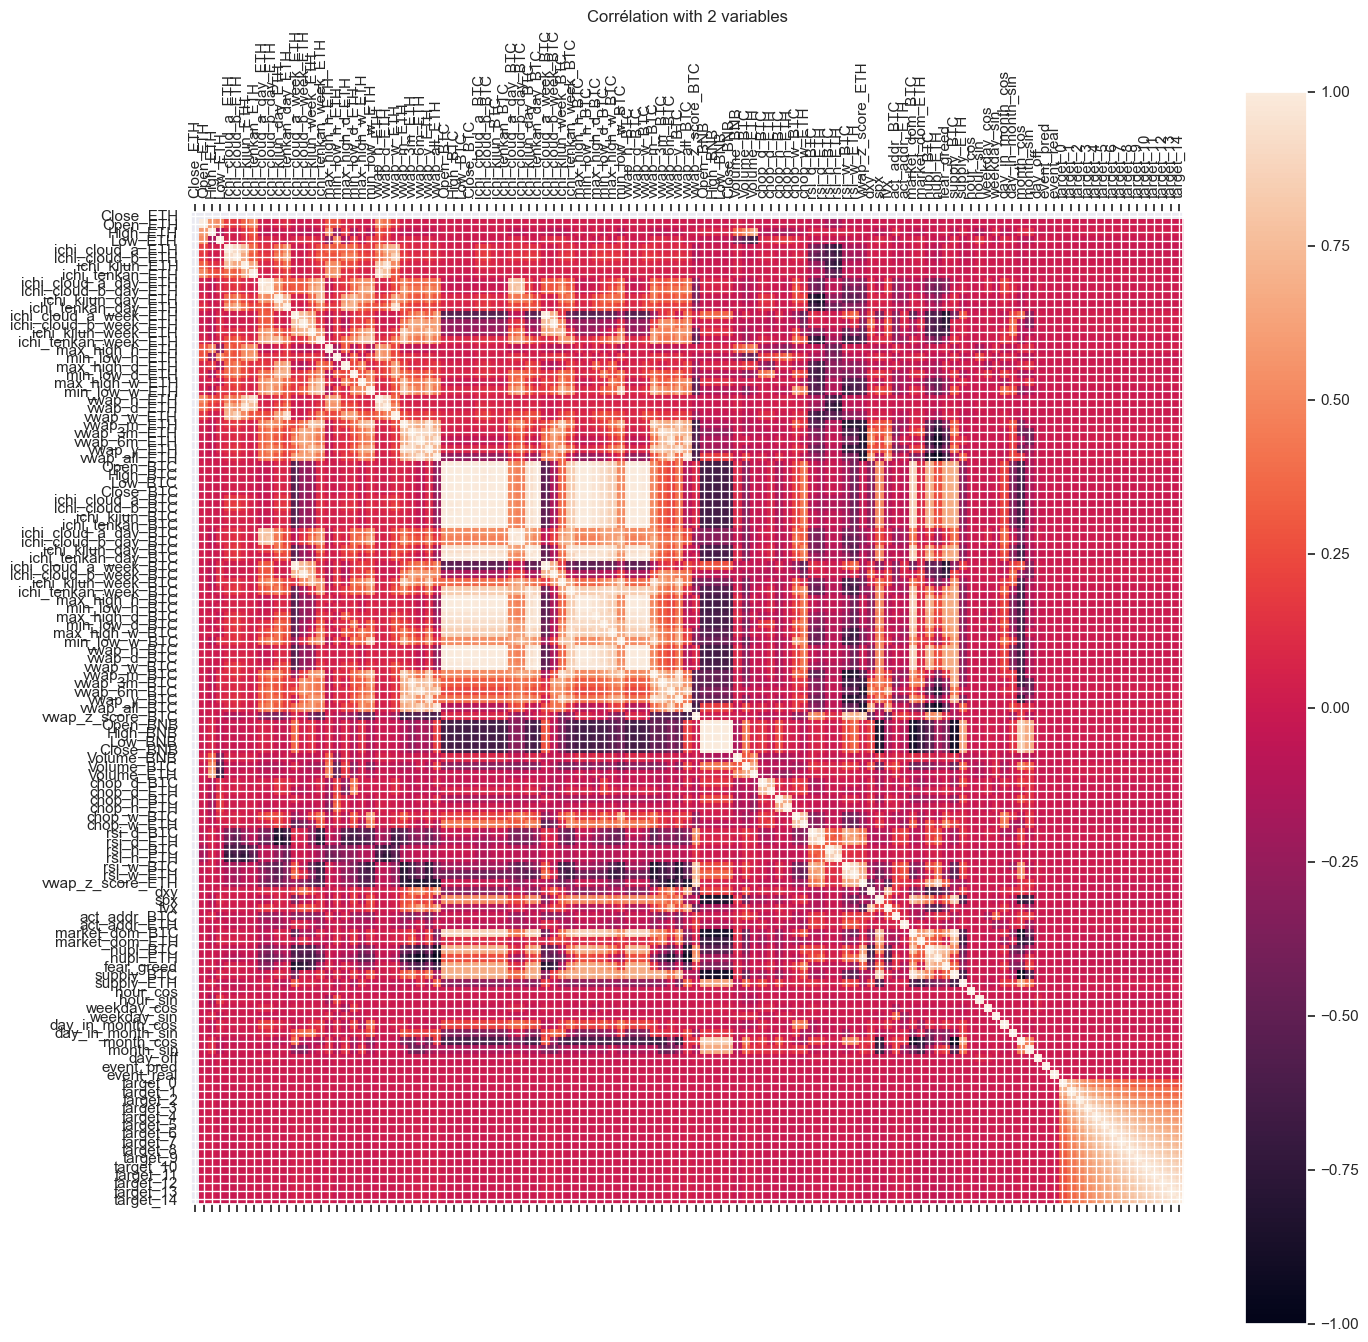

In [61]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


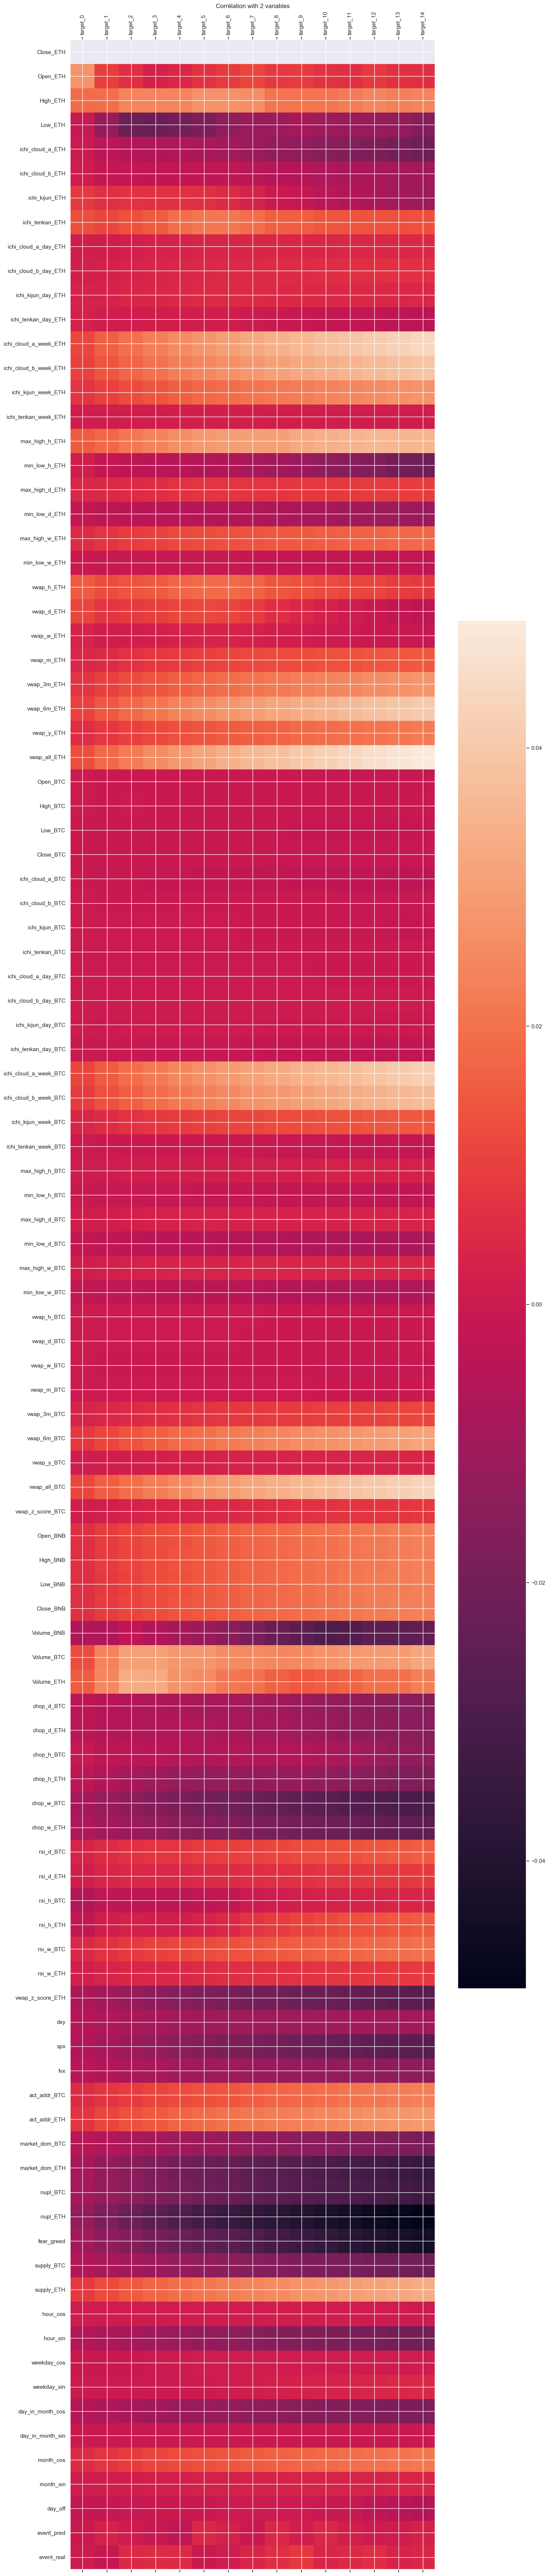

In [62]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


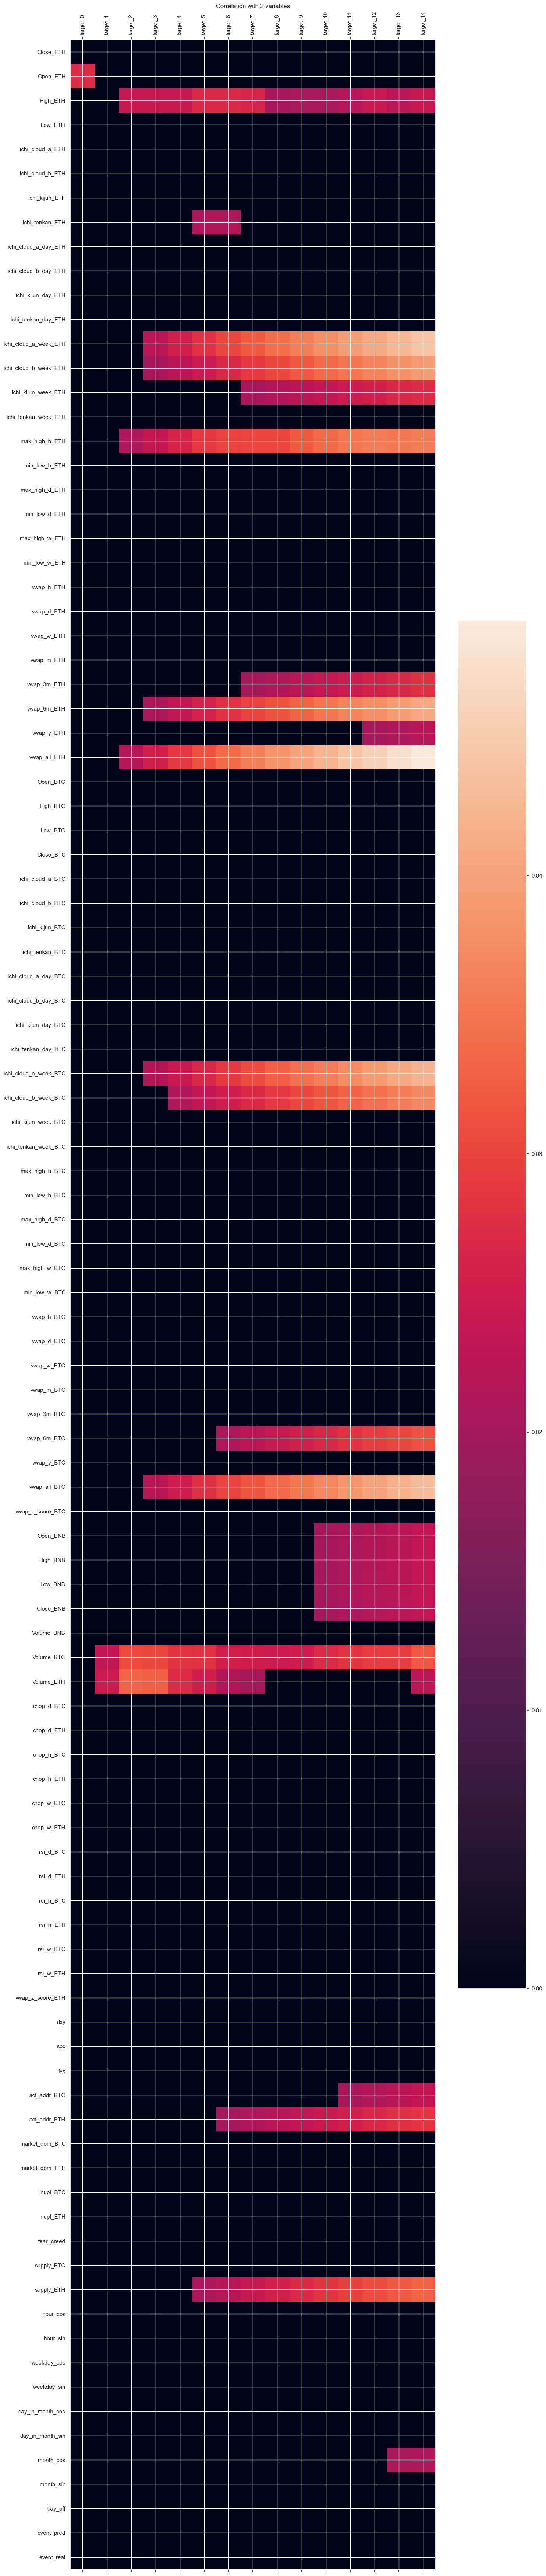

In [63]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [64]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

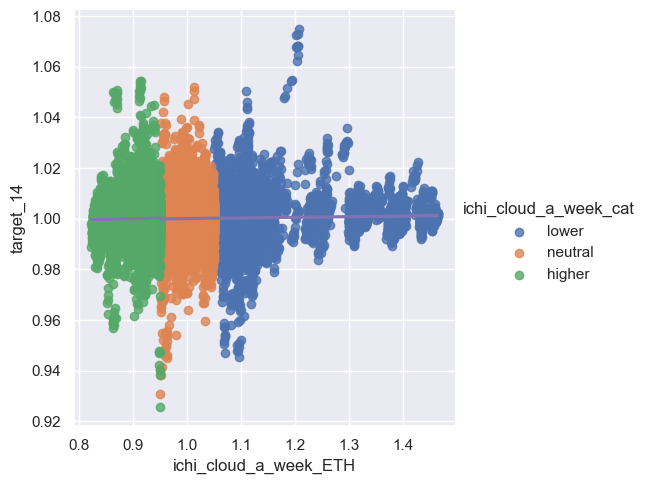

In [65]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

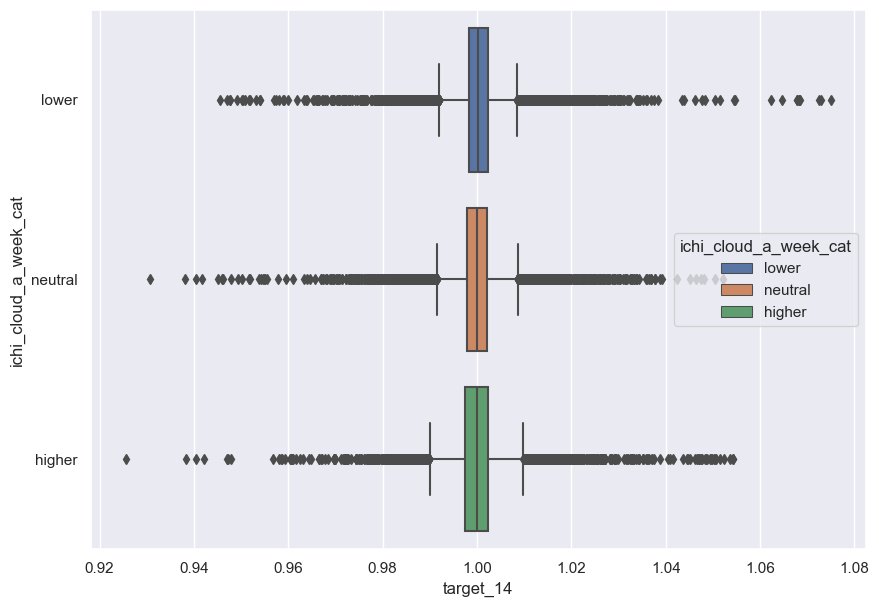

In [66]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [67]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


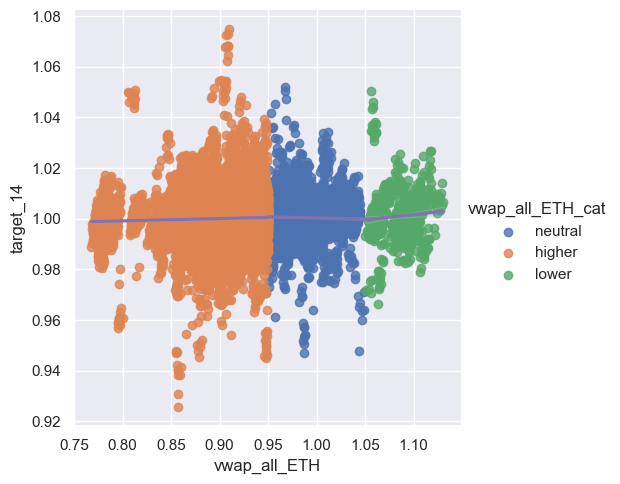

In [68]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

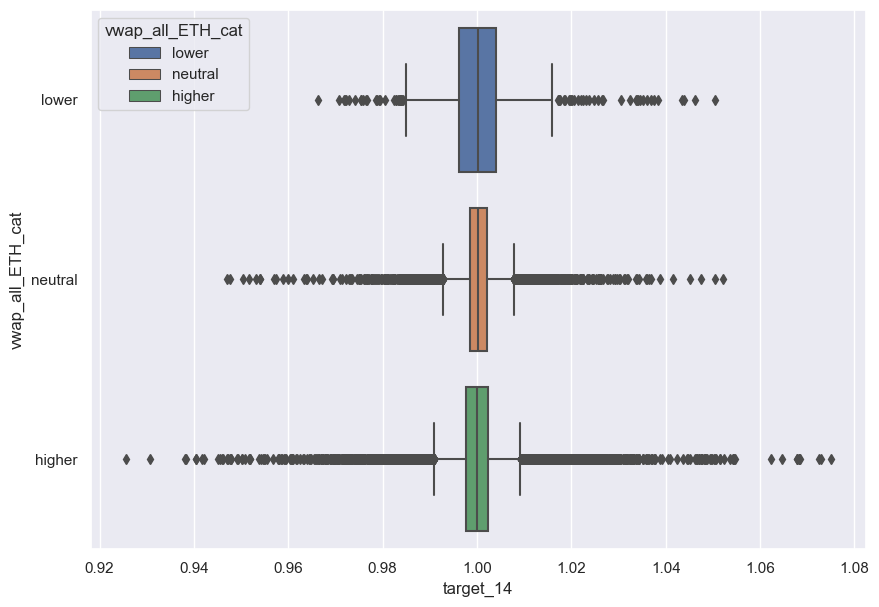

In [69]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

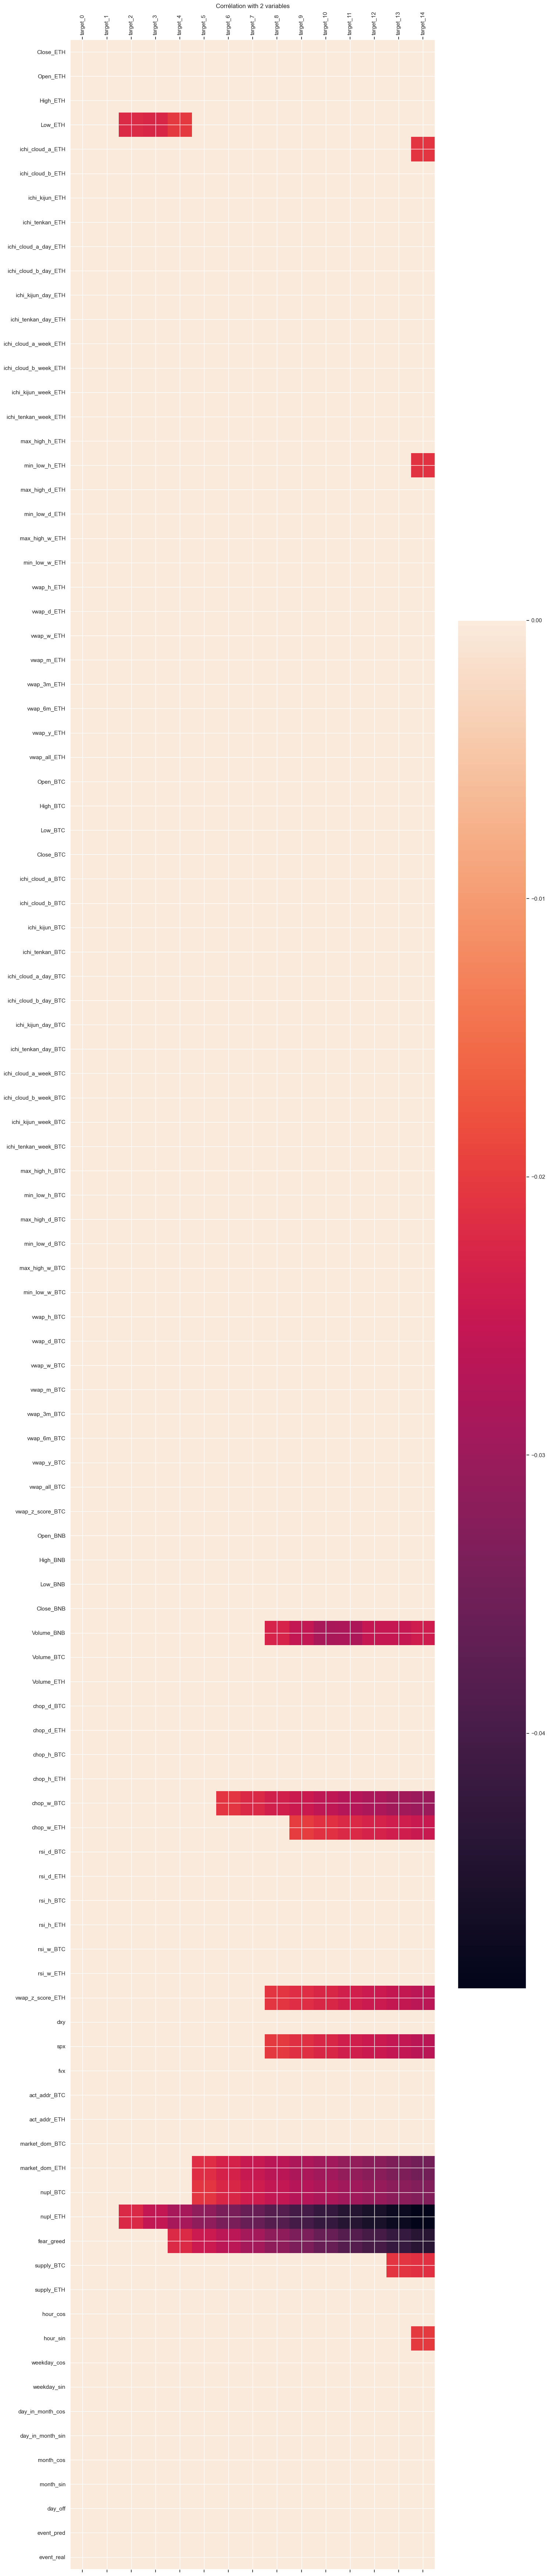

In [70]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

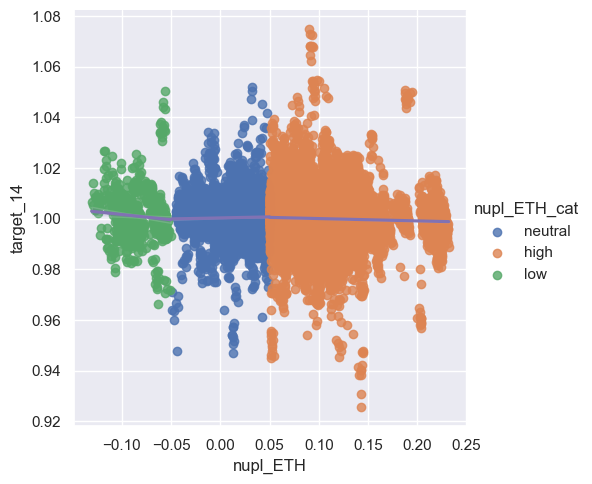

In [71]:


list_nupl_level=["low", "neutral", "high"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='nupl_ETH_cat'>

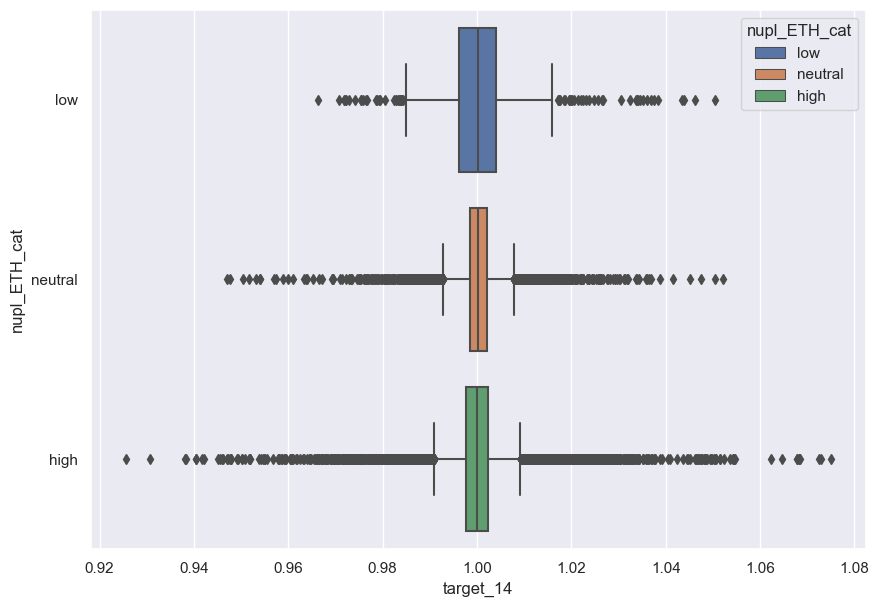

In [72]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)

In [73]:
df["target_14"].describe()

count    52614.000000
mean         1.000154
std          0.006007
min          0.925613
25%          0.997893
50%          1.000047
75%          1.002302
max          1.074927
Name: target_14, dtype: float64

In [74]:
df["target_1"].describe()

count    52614.000000
mean         1.000020
std          0.002204
min          0.967271
25%          0.999170
50%          1.000011
75%          1.000858
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

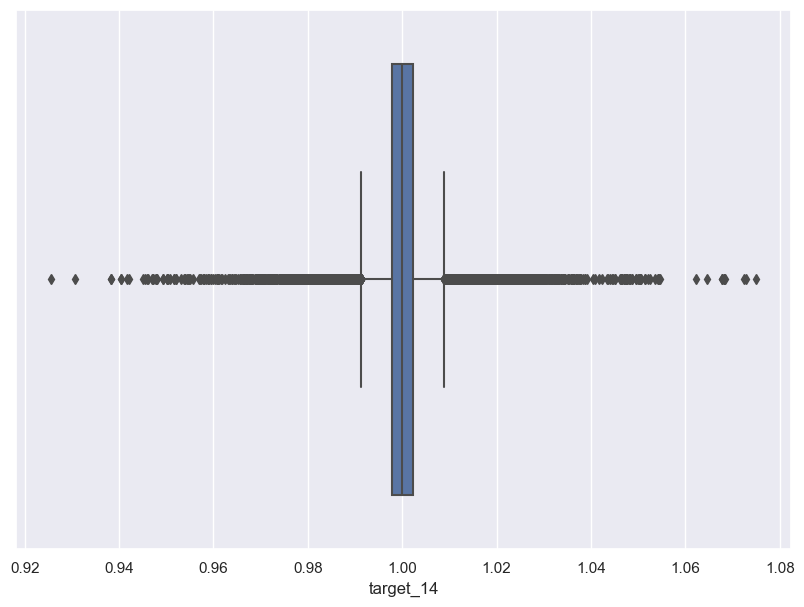

In [75]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [76]:
y_train

array([[0.99979063, 0.99896151, 0.99882751, ..., 0.99942213, 0.99925463,
        0.99937188],
       [0.99917071, 0.99903668, 0.99892778, ..., 0.99946389, 0.99958117,
        0.99954766],
       [0.99986586, 0.99975687, 0.99948021, ..., 1.0004108 , 1.00037726,
        1.00064554],
       ...,
       [0.99994777, 0.99984852, 0.99974928, ..., 1.0034265 , 1.0039645 ,
        1.00510841],
       [0.99990075, 0.9998015 , 1.0001985 , ..., 1.00401695, 1.00516091,
        1.00449229],
       [0.99990074, 1.00029777, 1.00107094, ..., 1.00526068, 1.004592  ,
        1.00436214]])

In [77]:
y_train_sca

array([[-0.06617876, -0.25457352, -0.28502116, ..., -0.14990977,
        -0.18796932, -0.16132763],
       [-0.20703854, -0.23749256, -0.26223644, ..., -0.14042039,
        -0.11377312, -0.12138663],
       [-0.04908362, -0.07384804, -0.13671158, ...,  0.0747385 ,
         0.06711868,  0.12807726],
       ...,
       [-0.03047293, -0.05302326, -0.0755736 , ...,  0.75997566,
         0.88222222,  1.1421445 ],
       [-0.04115584, -0.06370736,  0.0264987 , ...,  0.89413849,
         1.15407435,  1.00214837],
       [-0.04115808,  0.04905693,  0.22473878, ...,  1.1767445 ,
         1.02480344,  0.9725737 ]])

## Autoencoder

In [78]:
X_train.shape

(52614, 48, 104)

### Model creation

### Training

Training: TS 0.9891 - units 128 - enc_dim 32 - drop 0.05 ...
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         119296    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 32)          4128      
                                                                 
Total params: 123,424
Trainable params: 123,424
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
______________________

Epoch 1/30


2023-07-05 07:23:43.027030: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1645/1645 [==============================] - 73s 43ms/step - loss: 0.1077 - val_loss: 0.0658
Epoch 2/30
1645/1645 [==============================] - 72s 44ms/step - loss: 0.0410 - val_loss: 0.0574
Epoch 3/30
1645/1645 [==============================] - 71s 43ms/step - loss: 0.0311 - val_loss: 0.0511
Epoch 4/30
1645/1645 [==============================] - 71s 43ms/step - loss: 0.0258 - val_loss: 0.0476
Epoch 5/30
1645/1645 [==============================] - 69s 42ms/step - loss: 0.0239 - val_loss: 0.0493
Epoch 6/30
1645/1645 [==============================] - 69s 42ms/step - loss: 0.0225 - val_loss: 0.0498
Epoch 7/30
1645/1645 [==============================] - 70s 42ms/step - loss: 0.0198 - val_loss: 0.0463
Epoch 8/30
1645/1645 [==============================] - 70s 43ms/step - loss: 0.0190 - val_loss: 0.0495
Epoch 9/30
1645/1645 [==============================] - 70s 43ms/step - loss: 0.0183 - val_loss: 0.0443
Epoch 10/30
1645/1645 [==============================] - 71s 43ms/step - lo

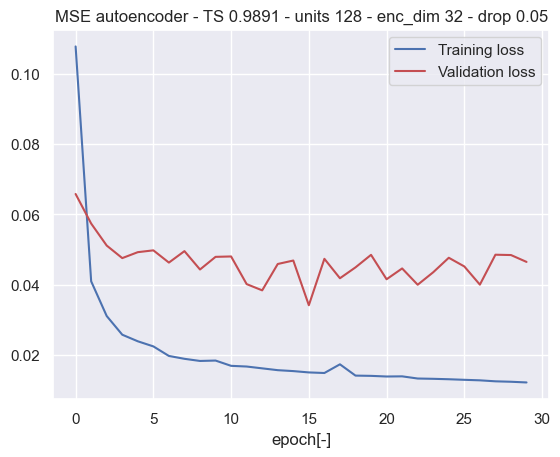

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e32_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e32_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e32_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e32_d0.05/assets


Save models...


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


In [79]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
epochs = 30 #100 #150 #6 #300
patience = 0 #20 #40 #3 #100
for n_unit_enc in [128]: #[104]: #
    for encoding_dim in [32]:
        for dropout_autoenc in [0.05]: #[0.25]:
            # check already done ? 
            #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
            plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
            path_jpg = os.path.join(path_data,
                f"output_MSE autoencoder - {plt_name}.jpg")
            if os.path.exists(path_jpg) | (MODE_TRAIN_AE == False):
                print(f"BE CAREFUL ! : {path_jpg} exists or training inactivated => no training done...")
                continue
            print(f"Training: {plt_name} ...")
            # Init
            tf.keras.backend.clear_session()
            tf.random.set_seed(0)
            # Input dimension
            input_dim = X_train.shape[-1]
            # Reduced encoded input dimension
            # 64/8/0.5
            # Définir l'encodeur
            encoder_inputs = keras.Input(shape=(None, input_dim))
            encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
            #encoder = layers.LSTM(64, return_sequences=True)(encoder)
            #encoder = layers.LSTM(16, return_sequences=True)(encoder)
            encoder = layers.Dropout(dropout_autoenc)(encoder)
            encoder_outputs = layers.Dense(encoding_dim)(encoder)
            encoder_model = keras.Model(encoder_inputs, encoder_outputs)
            print(encoder_model.summary())
            # Définir le décodeur
            decoder_inputs = keras.Input(shape=(None, encoding_dim))
            #decoder = layers.LSTM(16, return_sequences=True)(decoder_inputs)
            #decoder = layers.LSTM(64, return_sequences=True)(decoder)
            decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
            decoder = layers.Dropout(dropout_autoenc)(decoder)
            decoder_outputs = layers.Dense(input_dim)(decoder)
            decoder_model = keras.Model(decoder_inputs, decoder_outputs)
            print(decoder_model.summary())
            # Define complete autoencoder 
            autoencoder_inputs = keras.Input(shape=(None, input_dim))
            encoded = encoder_model(autoencoder_inputs)
            decoded = decoder_model(encoded)
            autoencoder = keras.Model(autoencoder_inputs, decoded)
            # Compile : autoencoder
            autoencoder.compile(optimizer="adam", loss="mse")
            # earlystop 
            es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                            monitor='val_loss', mode='auto', restore_best_weights=True)
            # Train
            if patience == 0:
                autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                verbose=1)
            else:
                autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1, callbacks=[es])

            plot_train_history(
                autoenc_step_history,f"MSE autoencoder - {plt_name}",
                saveFolder=path_data)
            autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
            encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")

if MODE_TRAIN_AE:
    print("Save models...")
    autoencoder.save(path_mdl_autoencoder)
    encoder_model.save(path_mdl_encoder)
else:
    print("Load models...")
    autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
    print(autoencoder.summary())
    encoder_model = tf.keras.models.load_model(path_mdl_encoder)
    print(encoder_model.summary())


### Save model

In [80]:
# TODO select best model


In [81]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [82]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [87]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

1645/1645 [==============================] - 30s 18ms/step


(52614, 48, 104)

### Results

In [88]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

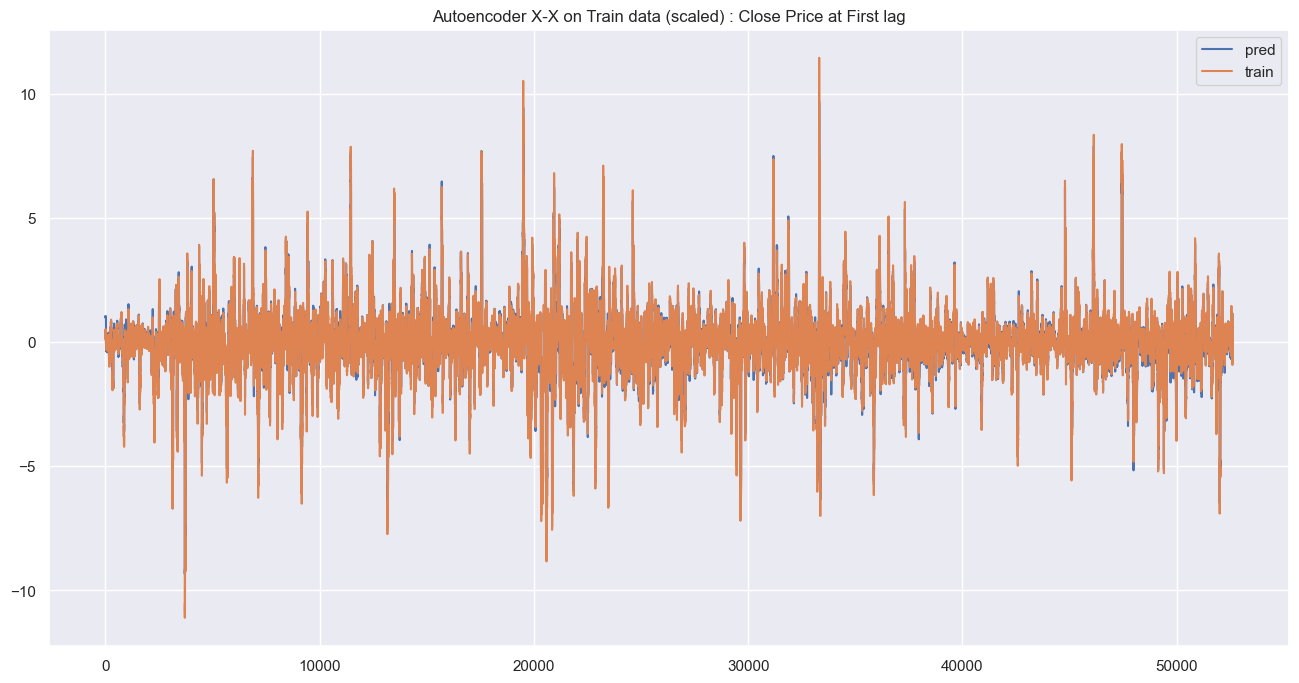

In [89]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE by lags and by features

In [90]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)
df_mae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_train.index))]
df_mae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(52614, 48, 104)
(52614, 48, 104)
(48, 104)
(1, 104)


In [91]:
df_mae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.113569  0.151272  0.091520  0.103786          0.121347   
lag_1    0.090326  0.090892  0.080606  0.089663          0.100900   
lag_2    0.066082  0.066524  0.059960  0.069916          0.086878   
lag_3    0.063345  0.060134  0.057676  0.067562          0.082312   
lag_4    0.057097  0.055643  0.052967  0.063056          0.079323   
lag_5    0.054541  0.052362  0.050274  0.060624          0.077339   
lag_6    0.053019  0.051282  0.049116  0.059426          0.075918   
lag_7    0.052208  0.050554  0.048389  0.058759          0.074958   
lag_8    0.051806  0.050228  0.047999  0.058399          0.074143   
lag_9    0.051535  0.050084  0.047777  0.058199          0.073501   
lag_10   0.051314  0.049978  0.047598  0.058022          0.072880   
lag_11   0.051217  0.049919  0.047485  0.057959          0.072328   
lag_12   0.051120  0.049881  0.047381  0.057900          0.071802   
lag_13   0.051027  0.049874  0.047296  0.057860          0.071249   
lag_14   0.050960  0.049901  0.047237  0.057821          0.070680   
lag_15   0.050872  0.049889  0.047180  0.057788          0.070013   
lag_16   0.050783  0.049853  0.047119  0.057729          0.069309   
lag_17   0.050720  0.049831  0.047106  0.057698          0.068568   
lag_18   0.050672  0.049789  0.047040  0.057639          0.067821   
lag_19   0.050608  0.049757  0.046994  0.057604          0.067106   
lag_20   0.050531  0.049731  0.046961  0.057542          0.066445   
lag_21   0.050491  0.049723  0.046949  0.057515          0.065870   
lag_22   0.050395  0.049694  0.046913  0.057416          0.065444   
lag_23   0.050344  0.049626  0.046864  0.057357          0.065106   
lag_24   0.050311  0.049604  0.046831  0.057305          0.064876   
lag_25   0.050247  0.049590  0.046807  0.057261          0.064745   
lag_26   0.050191  0.049590  0.046787  0.057253          0.064726   
lag_27   0.050167  0.049577  0.046779  0.057230          0.064703   
lag_28   0.050087  0.049551  0.046748  0.057203          0.064641   
lag_29   0.050045  0.049484  0.046707  0.057161          0.064585   
lag_30   0.049996  0.049463  0.046711  0.057141          0.064562   
lag_31   0.049907  0.049456  0.046676  0.057106          0.064526   
lag_32   0.049865  0.049418  0.046658  0.057067          0.064518   
lag_33   0.049837  0.049365  0.046614  0.057033          0.064500   
lag_34   0.049781  0.049343  0.046596  0.056993          0.064492   
lag_35   0.049767  0.049348  0.046578  0.056986          0.064498   
lag_36   0.049699  0.049341  0.046550  0.056965          0.064504   
lag_37   0.049636  0.049316  0.046521  0.056941          0.064516   
lag_38   0.049563  0.049281  0.046453  0.056863          0.064512   
lag_39   0.049504  0.049251  0.046391  0.056810          0.064499   
lag_40   0.049455  0.049240  0.046359  0.056775          0.064502   
lag_41   0.049362  0.049218  0.046340  0.056740          0.064498   
lag_42   0.049313  0.049174  0.046315  0.056712          0.064468   
lag_43   0.049273  0.049165  0.046323  0.056716          0.064479   
lag_44   0.049213  0.049110  0.046261  0.056694          0.064475   
lag_45   0.049119  0.049084  0.046207  0.056629          0.064448   
lag_46   0.049048  0.049054  0.046135  0.056581          0.064436   
lag_47   0.048960  0.049061  0.046098  0.056531          0.064408   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.119068        0.126218         0.115739   
lag_1           0.100814        0.115954         0.108013   
lag_2           0.086062        0.100584         0.089513   
lag_3           0.082498        0.096717         0.085295   
lag_4           0.079302        0.091157         0.078008   
lag_5           0.077891        0.086795         0.071663   
lag_6           0.076868        0.082998         0.066476   
lag_7           0.076017        0.079774         0.062501   
lag_8           0.075180        0.076638         0.059659   
lag_9           

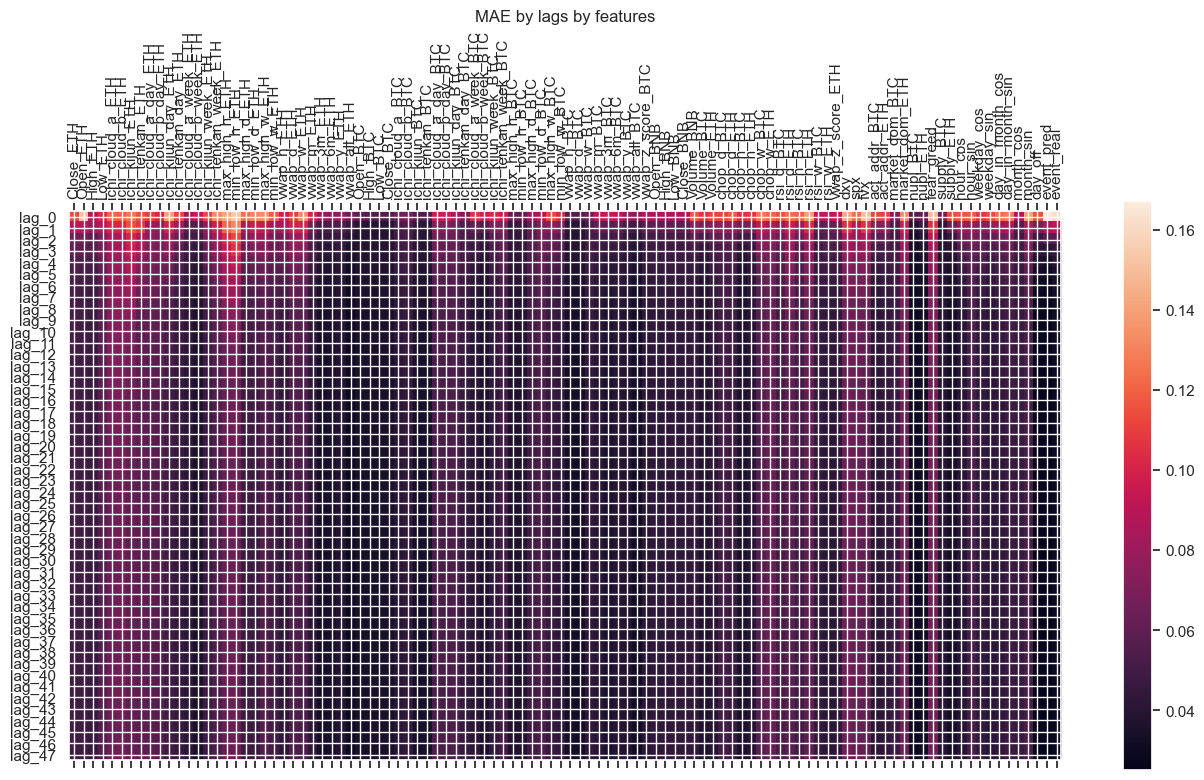

In [92]:
plot_corr(df_mae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

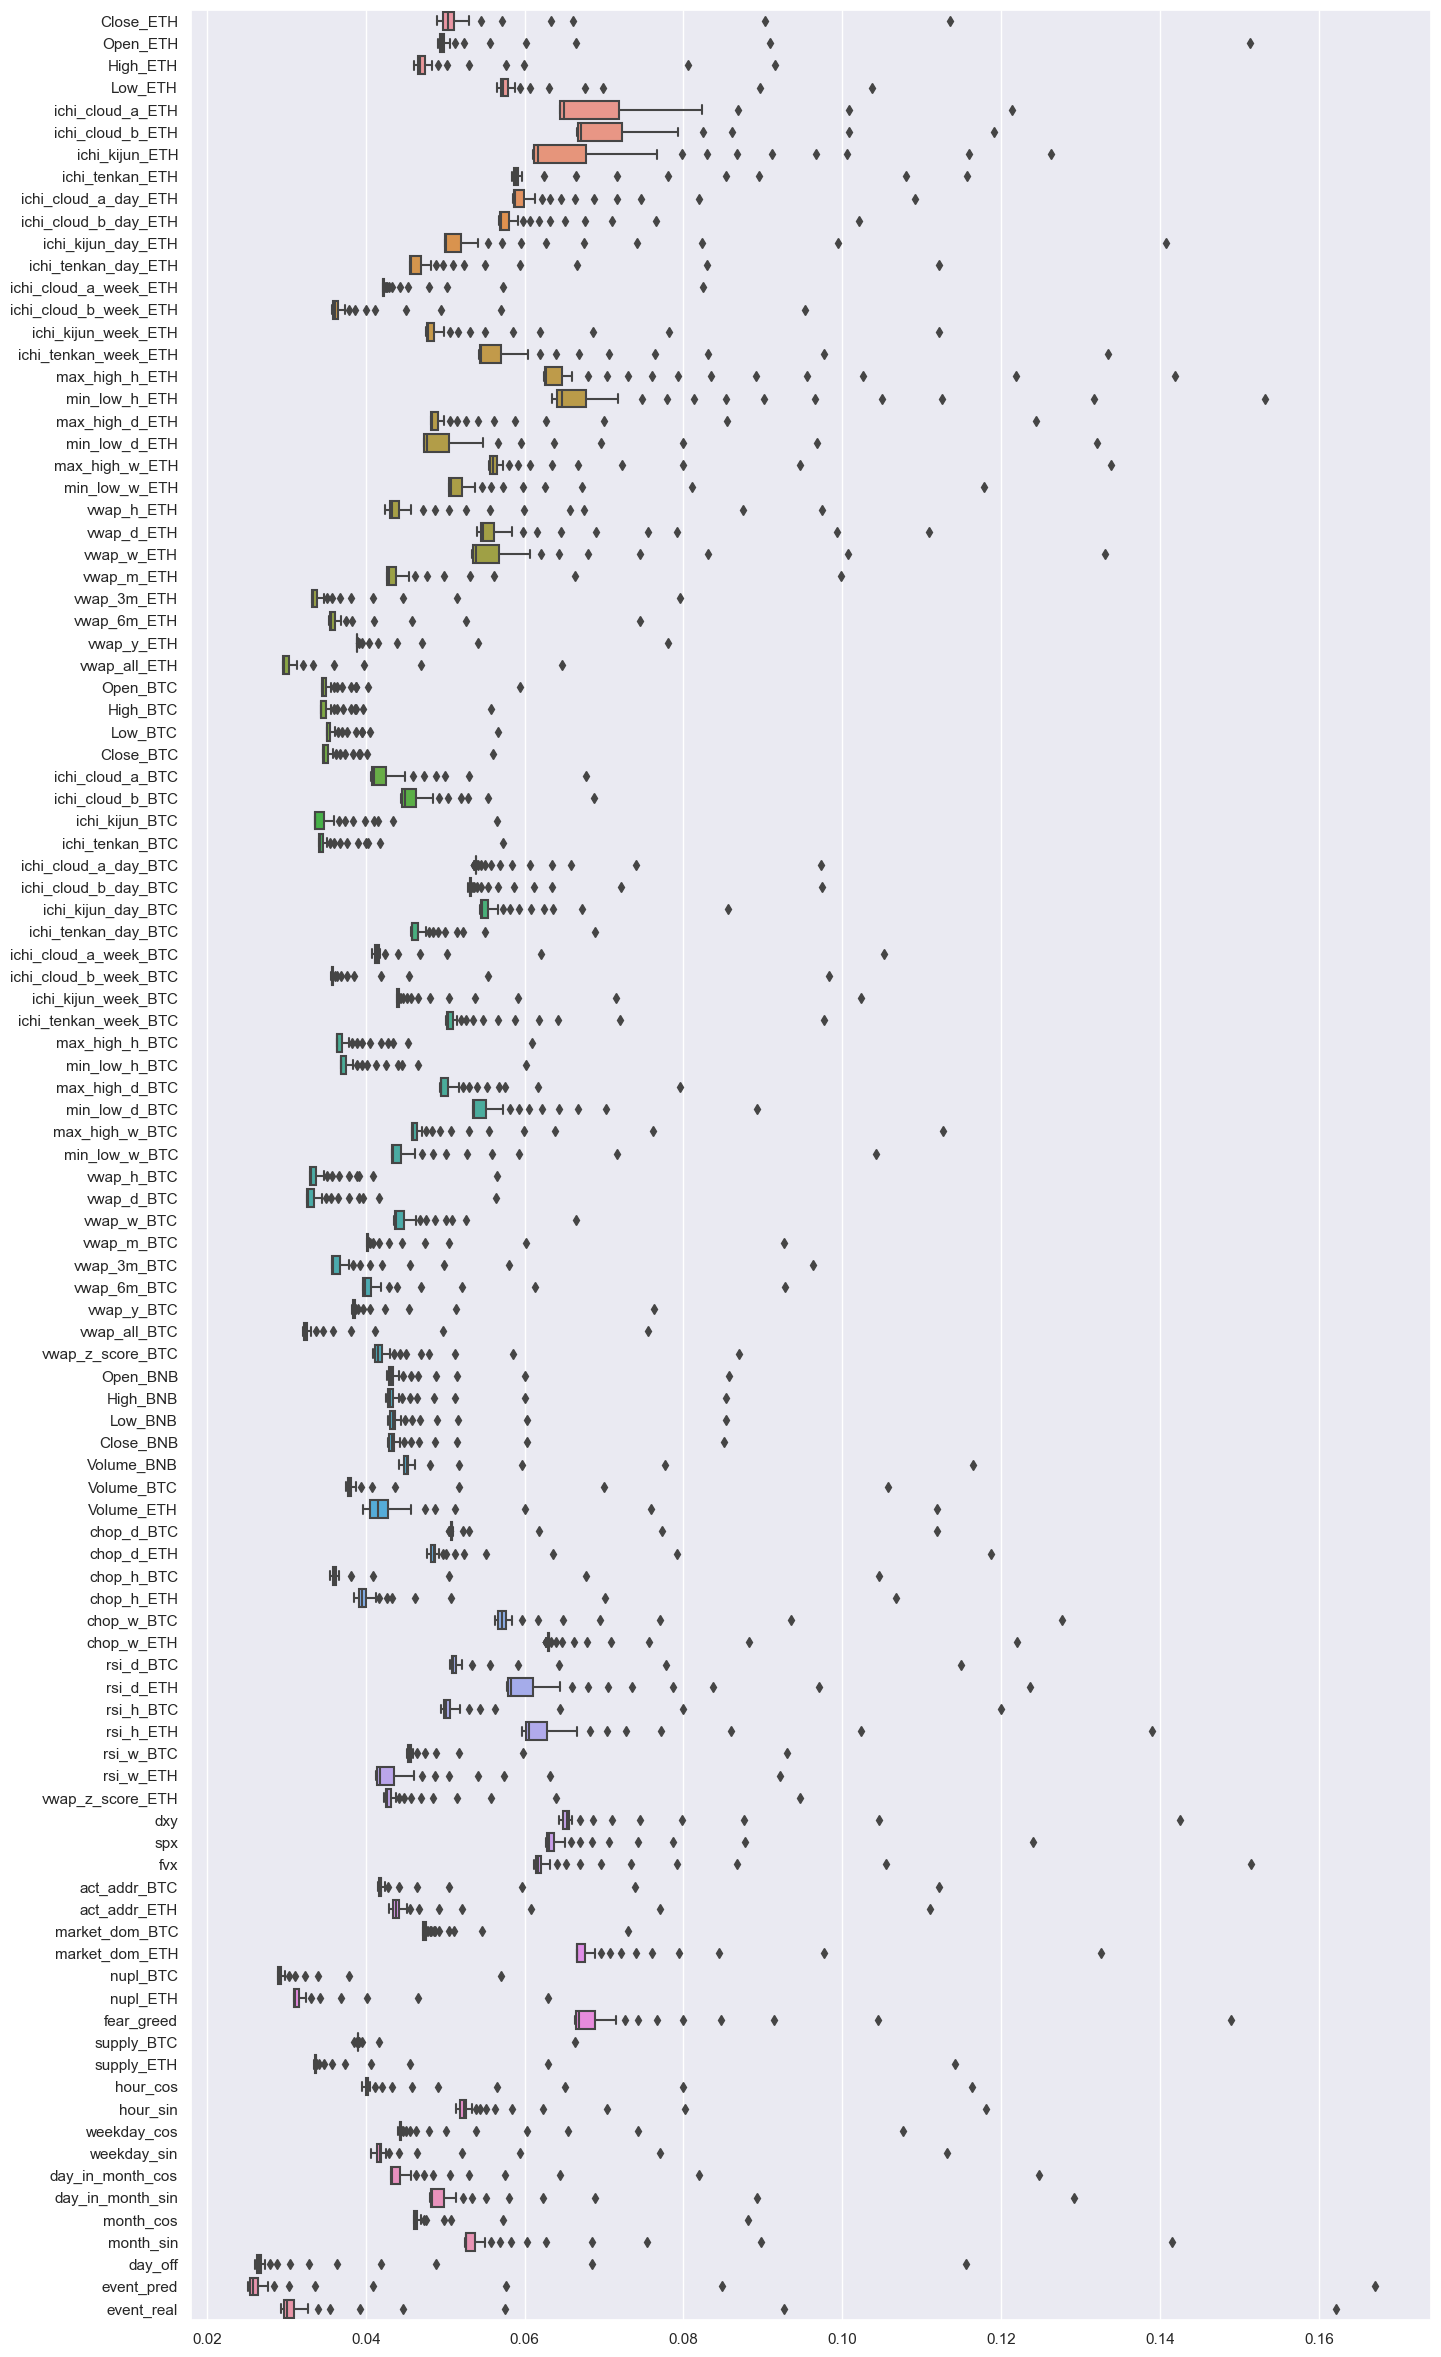

In [93]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_train, orient="h")

In [90]:
df_mae_train_feat

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0   0.062564  0.062545  0.045195  0.05816          0.075164          0.077568   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0        0.073812         0.063897              0.060886   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0              0.054371  ...  0.054993     0.056091     0.046636   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin   day_off  \
0          0.051427          0.052002   0.044459   0.046308  0.030011   

   event_pred  event_real  
0    0.037937    0.039901  

[1 rows x 104 columns]

Text(0.5, 1.0, 'MAE per feature')

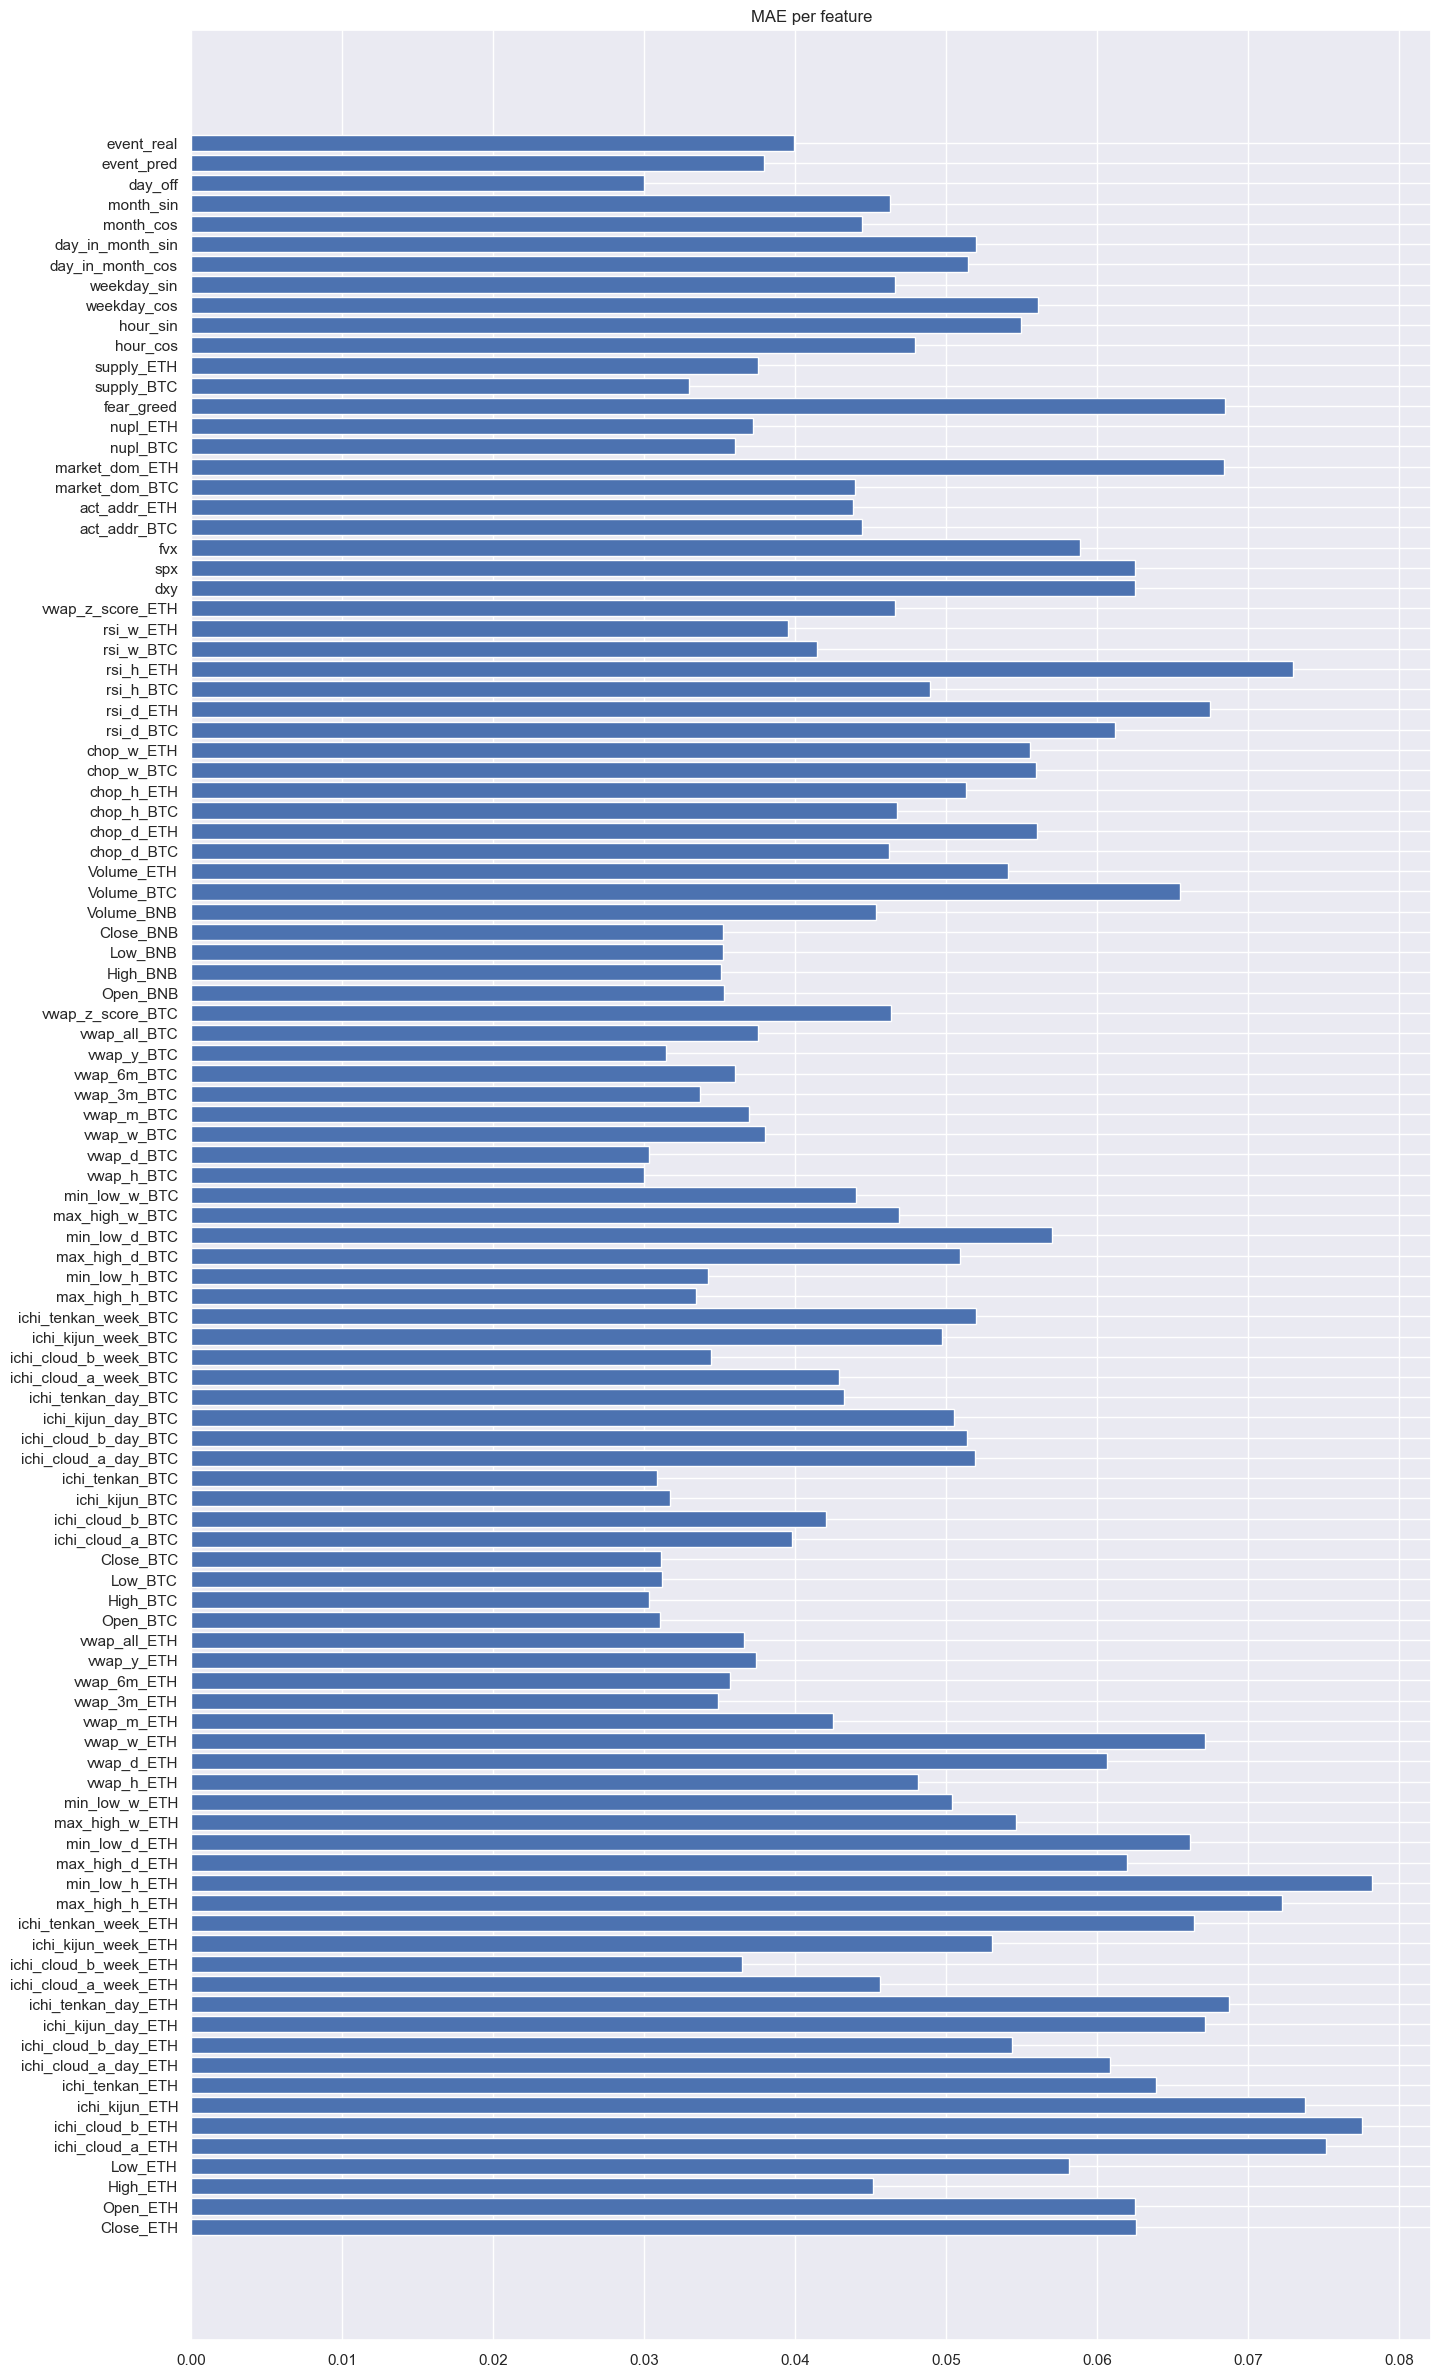

In [91]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_train_feat.columns, df_mae_train_feat.values[0])
plt.title("MAE per feature")

In [94]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(52614,)
(52614,)
[1196.32 1195.38 1194.55 ... 1921.28 1919.98 1917.54]
[1196.32 1195.38 1194.55]


In [95]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([1.001169  , 1.0010657 , 1.0009995 , ..., 0.99947345, 0.9998424 ,
       0.99962544], dtype=float32)

[1196.32 1195.38 1194.55 ... 1921.28 1919.98 1917.54]
[1203.0589889  1202.8179162  1201.92764282 ... 1918.33308065 1917.35152103
 1915.55887396]


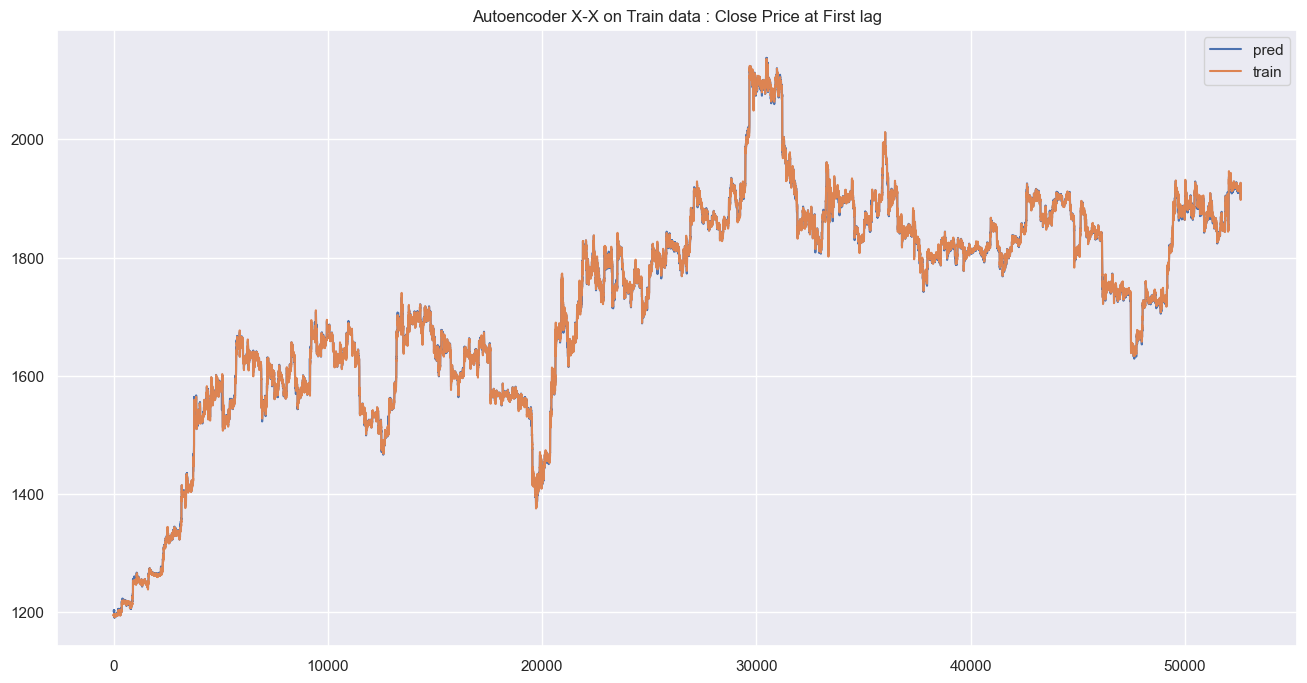

In [96]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### on Test data

In [97]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

17/17 [==============================] - 0s 25ms/step


(517, 48, 104)

In [98]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-07-02 21:40:00'

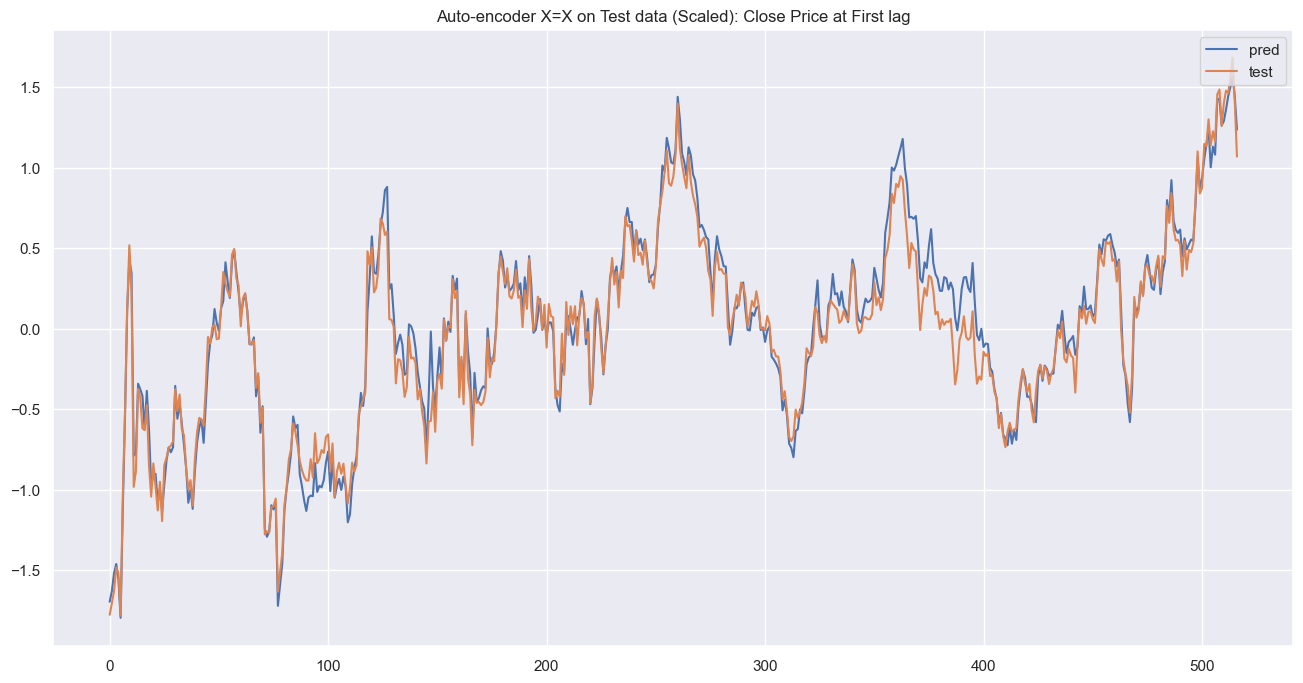

In [99]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [100]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1921.59 1921.78 1921.   1922.94 1924.56 1923.95 1933.33 1939.82 1949.84]
X test pred :  [1922.77548262 1922.8732782  1922.62158794 1923.25385438 1924.0106002
 1923.76144917 1932.12138113 1939.38409402 1949.80649546]


[1921.59 1921.78 1921.   1922.94 1924.56 1923.95 1933.33 1939.82 1949.84
 1957.19 1954.33 1934.39 1936.59 1942.32 1942.05 1939.75 1939.4  1940.76
 1935.57 1933.1  1937.21 1935.11 1933.28 1934.83 1931.63 1937.02 1937.48
 1937.79 1939.14 1940.54 1940.34 1939.28 1939.86 1938.11 1937.25 1935.27
 1936.21 1936.44 1934.88 1936.67 1937.77 1938.31 1938.45 1940.   1941.57
 1948.3  1946.29 1947.99 1947.11 1945.19 1944.99 1947.16 1950.47 1948.88
 1947.83 1948.46 1949.94 1951.26 1949.15 1949.94 1948.14 1948.69 1949.18
 1949.   1948.08 1948.42 1948.75 1949.84 1949.92 1950.2  1949.13 1949.52
 1949.8  1949.6  1949.01 1950.15 1951.18 1946.2  1947.14 1946.2  1947.61
 1947.3  1948.34 1951.21 1950.6  1951.38 1948.9  1947.56 1946.77 1947.07
 1949.21 1947.22 1949.41 1948.01 1948.2  1947.09 1946.5  1946.24 1945.57
 1945.67 1945.16 1944.8  1945.91 1943.56 1944.37 1944.94 1946.34 1948.28
 1946.27 1946.3  1947.85 1949.82 1950.17 1950.15 1955.61 1954.34 1959.17
 1956.73 1968.8  1968.81 1968.73 1965.78 1966.83 19

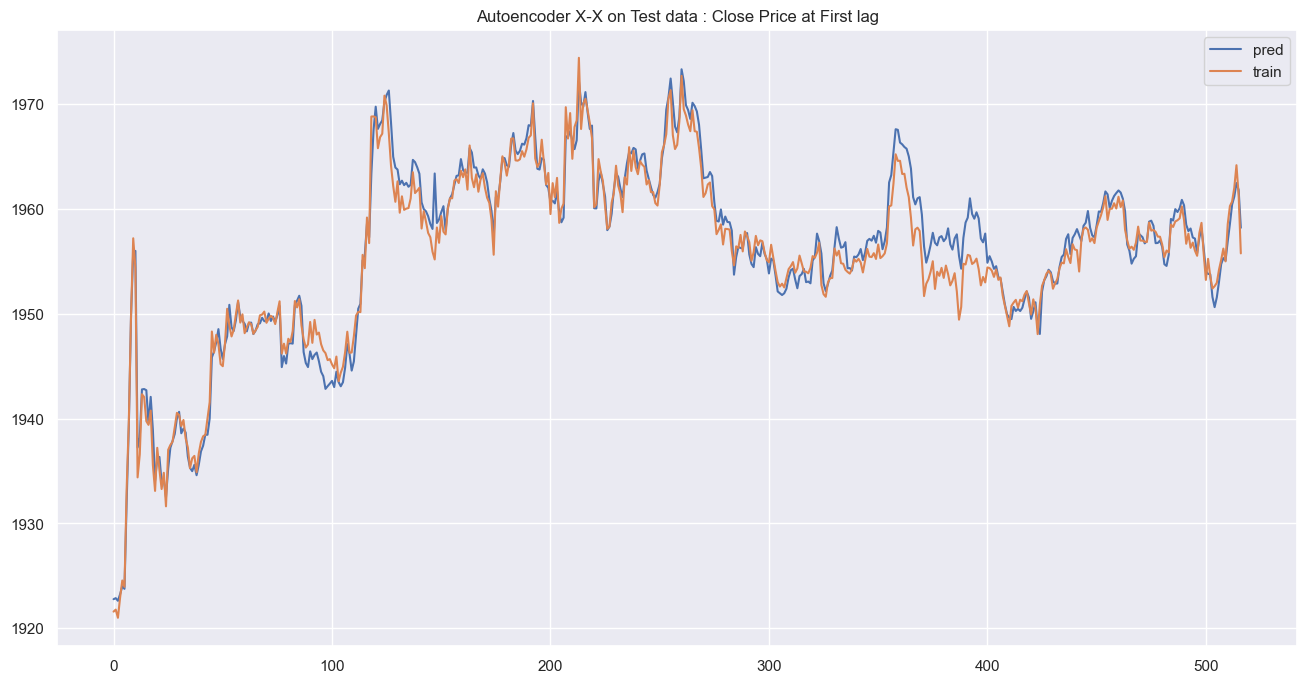

In [101]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [102]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(517, 48, 104)
(517, 48, 104)
(48, 104)
(1, 104)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.113569  0.151272  0.091520  0.103786          0.121347   
lag_1    0.090326  0.090892  0.080606  0.089663          0.100900   
lag_2    0.066082  0.066524  0.059960  0.069916          0.086878   
lag_3    0.063345  0.060134  0.057676  0.067562          0.082312   
lag_4    0.057097  0.055643  0.052967  0.063056          0.079323   
...           ...       ...       ...       ...               ...   
lag_43   0.046462  0.055493  0.042755  0.057348          0.058112   
lag_44   0.046728  0.055608  0.042876  0.057274          0.057811   
lag_45   0.046201  0.055842  0.042769  0.057399          0.057642   
lag_46   0.046168  0.055527  0.042839  0.057189          0.057419   
lag_47   0.046002  0.055373  0.042833  0.057434          0.057238   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.119068        0.126218         0.115739   
lag_1           0.100814        0.115954         0.108013   
lag_2           0.086062        0.100584         0.089513   
lag_3           0.082498        0.096717         0.085295   
lag_4           0.079302        0.091157         0.078008   
...                  ...             ...              ...   
lag_43          0.054392        0.054738         0.054301   
lag_44          0.054401        0.054531         0.053922   
lag_45          0.054539        0.054555         0.053690   
lag_46          0.054554        0.054278         0.053619   
lag_47          0.054785        0.054457         0.053676   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
lag_0               0.109094              0.102144  ...     0.107623   
lag_1               0.081953              0.076480  ...     0.074304   
lag_2               0.074633              0.070939  ...     0.065505   
lag_3               0.071692              0.067542  ...     0.060327   
lag_4               0.068757              0.065105  ...     0.053849   
...                      ...                   ...  ...          ...   
lag_43              0.128723              0.118993  ...     0.121916   
lag_44              0.128802              0.119135  ...     0.121960   
lag_45              0.128975              0.119311  ...     0.122029   
lag_46              0.129119              0.119438  ...     0.122189   
lag_47              0.129306              0.119534  ...     0.122225   

        weekday_sin  day_in_month_cos  day_in_month_sin  month_cos  month_sin  \
lag_0      0.113127          0.124805          0.129190   0.088166   0.141555   
lag_1      0.077046          0.081947          0.089213   0.057278   0.089755   
lag_2      0.059470          0.064430          0.068836   0.050770   0.075421   
lag_3      0.052122          0.057490          0.062279   0.049879   0.068508   
lag_4      0.046506          0.053006          0.057991   0.047588   0.062717   
...             ...               ...               ...        ...        ...   
lag_43     0.121926          0.163805          0.175668   0.096523   0.398585   
lag_44     0.121801          0.164302          0.175133   0.096614   0.398758   
lag_45     0.121756          0.164670          0.174678   0.096660   0.399018   
lag_46     0.121514          0.165153          0.174190   0.096763   0.399179   
lag_47     0.121291          0.165434          0.173770   0.096803   0.399428   

         day_off  event_pred  event_real  dataset  
lag_0   0.115561    0.167062    0.162163    TRAIN  
lag_1   0.068472    0.084806    0.092668    TRAIN  
lag_2   0.048849    0.057592    0.057559    TRAIN  
lag_3   0.041919    0.040890    0.044633    TRAIN  
lag_4   0.036373    0.033656    0.039267    TRAIN  
...          ...         ...         ...      ...  
lag_43  0.251511    0.065653    0.109729     TEST  
lag_44  0.251628    0.065519    0.109519     TEST  
lag_45  0.251731    0.065266    0.109363     TEST  
lag_46  0.251856    0.065077    0.109149     TEST  
lag_47  0.251905    0.064920    0.10

In [103]:
df_mae_ae_comp

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.113569  0.151272  0.091520  0.103786          0.121347   
lag_1    0.090326  0.090892  0.080606  0.089663          0.100900   
lag_2    0.066082  0.066524  0.059960  0.069916          0.086878   
lag_3    0.063345  0.060134  0.057676  0.067562          0.082312   
lag_4    0.057097  0.055643  0.052967  0.063056          0.079323   
...           ...       ...       ...       ...               ...   
lag_43   0.046462  0.055493  0.042755  0.057348          0.058112   
lag_44   0.046728  0.055608  0.042876  0.057274          0.057811   
lag_45   0.046201  0.055842  0.042769  0.057399          0.057642   
lag_46   0.046168  0.055527  0.042839  0.057189          0.057419   
lag_47   0.046002  0.055373  0.042833  0.057434          0.057238   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.119068        0.126218         0.115739   
lag_1           0.100814        0.115954         0.108013   
lag_2           0.086062        0.100584         0.089513   
lag_3           0.082498        0.096717         0.085295   
lag_4           0.079302        0.091157         0.078008   
...                  ...             ...              ...   
lag_43          0.054392        0.054738         0.054301   
lag_44          0.054401        0.054531         0.053922   
lag_45          0.054539        0.054555         0.053690   
lag_46          0.054554        0.054278         0.053619   
lag_47          0.054785        0.054457         0.053676   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
lag_0               0.109094              0.102144  ...     0.107623   
lag_1               0.081953              0.076480  ...     0.074304   
lag_2               0.074633              0.070939  ...     0.065505   
lag_3               0.071692              0.067542  ...     0.060327   
lag_4               0.068757              0.065105  ...     0.053849   
...                      ...                   ...  ...          ...   
lag_43              0.128723              0.118993  ...     0.121916   
lag_44              0.128802              0.119135  ...     0.121960   
lag_45              0.128975              0.119311  ...     0.122029   
lag_46              0.129119              0.119438  ...     0.122189   
lag_47              0.129306              0.119534  ...     0.122225   

        weekday_sin  day_in_month_cos  day_in_month_sin  month_cos  month_sin  \
lag_0      0.113127          0.124805          0.129190   0.088166   0.141555   
lag_1      0.077046          0.081947          0.089213   0.057278   0.089755   
lag_2      0.059470          0.064430          0.068836   0.050770   0.075421   
lag_3      0.052122          0.057490          0.062279   0.049879   0.068508   
lag_4      0.046506          0.053006          0.057991   0.047588   0.062717   
...             ...               ...               ...        ...        ...   
lag_43     0.121926          0.163805          0.175668   0.096523   0.398585   
lag_44     0.121801          0.164302          0.175133   0.096614   0.398758   
lag_45     0.121756          0.164670          0.174678   0.096660   0.399018   
lag_46     0.121514          0.165153          0.174190   0.096763   0.399179   
lag_47     0.121291          0.165434          0.173770   0.096803   0.399428   

         day_off  event_pred  event_real  dataset  
lag_0   0.115561    0.167062    0.162163    TRAIN  
lag_1   0.068472    0.084806    0.092668    TRAIN  
lag_2   0.048849    0.057592    0.057559    TRAIN  
lag_3   0.041919    0.040890    0.044633    TRAIN  
lag_4   0.036373    0.033656    0.039267    TRAIN  
...          ...         ...         ...      ...  
lag_43  0.251511    0.065653    0.109729     TEST  
lag_44  0.251628    0.065519    0.109519     TEST  
lag_45  0.251731    0.065266    0.109363     TEST  
lag_46  0.251856    0.065077    0.109149     TEST  
lag_47  0.251905    0.064920    0.10

In [104]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0      TRAIN   Close_ETH  0.113569
1      TRAIN   Close_ETH  0.090326
2      TRAIN   Close_ETH  0.066082
3      TRAIN   Close_ETH  0.063345
4      TRAIN   Close_ETH  0.057097
...      ...         ...       ...
9979    TEST  event_real  0.109729
9980    TEST  event_real  0.109519
9981    TEST  event_real  0.109363
9982    TEST  event_real  0.109149
9983    TEST  event_real  0.109039

[9984 rows x 3 columns]

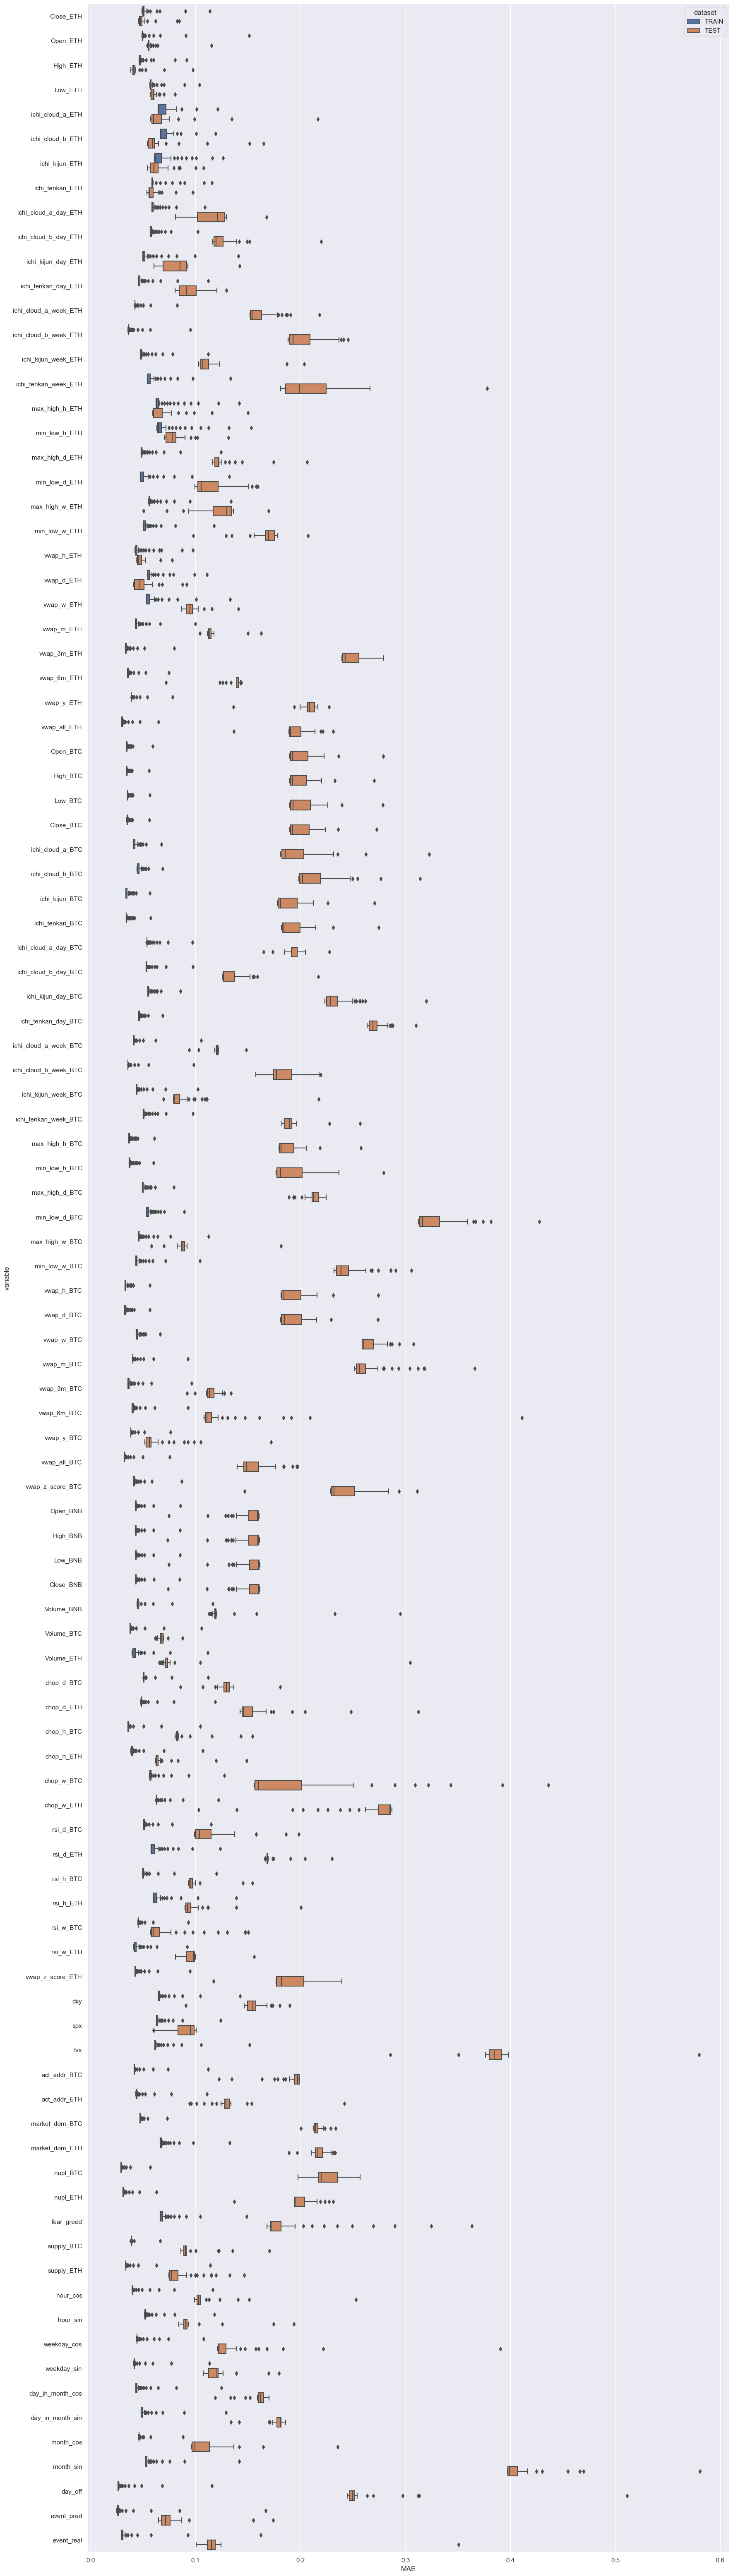

In [105]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

In [106]:
encoder_model.layers[3].get_weights()

[array([[ 0.842958  ,  0.5063907 ,  0.45411888, ...,  0.01483321,
          1.5882727 , -0.36009565],
        [-0.11249828,  0.11688974,  0.3335934 , ...,  0.04197494,
          0.25292554, -0.02393412],
        [ 0.04484627,  0.10462276,  0.05259531, ...,  0.12596804,
          0.16488573,  0.18017781],
        ...,
        [ 0.20715614,  0.02664023, -0.27958483, ...,  0.03626311,
         -0.06333295, -0.3152785 ],
        [ 0.02469139, -0.06407242,  0.2248977 , ..., -0.17936683,
         -0.03836902, -0.2845099 ],
        [-0.3445294 , -0.33057272, -0.27452046, ...,  0.15807603,
          0.34676582,  0.1296677 ]], dtype=float32),
 array([-4.6747448e-03,  2.6166180e-01, -1.1138902e-01,  1.3655911e-01,
        -3.0430162e-02,  2.7835512e-01, -1.2995267e-01,  1.8006296e-01,
         3.4296926e-02,  1.7117482e-01,  6.6168085e-02, -2.8049654e-01,
         3.2343674e-02, -4.1865915e-02,  3.6488373e-02,  3.2718420e-02,
        -2.9019001e-01,  1.9895509e-04,  9.0200752e-02,  1.2685241e-01

## Prediction Models

### LSTM all features

In [105]:
X_train_sca.shape

(52603, 48, 104)

In [106]:
X_train_sca.shape[-1]

104

In [107]:
X_train_sca.shape[-2:]

(48, 104)

In [108]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [107]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [108]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

1645/1645 [==============================] - 17s 10ms/step


(52614, 48, 32)

In [109]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

 6/17 [=========>....................] - ETA: 0s

17/17 [==============================] - 0s 15ms/step


(517, 48, 32)

In [110]:
if MODE_TRAIN_PREDICTOR:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



In [111]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [112]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [113]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((52614, 48, 36), (517, 48, 36))

#### Correlations

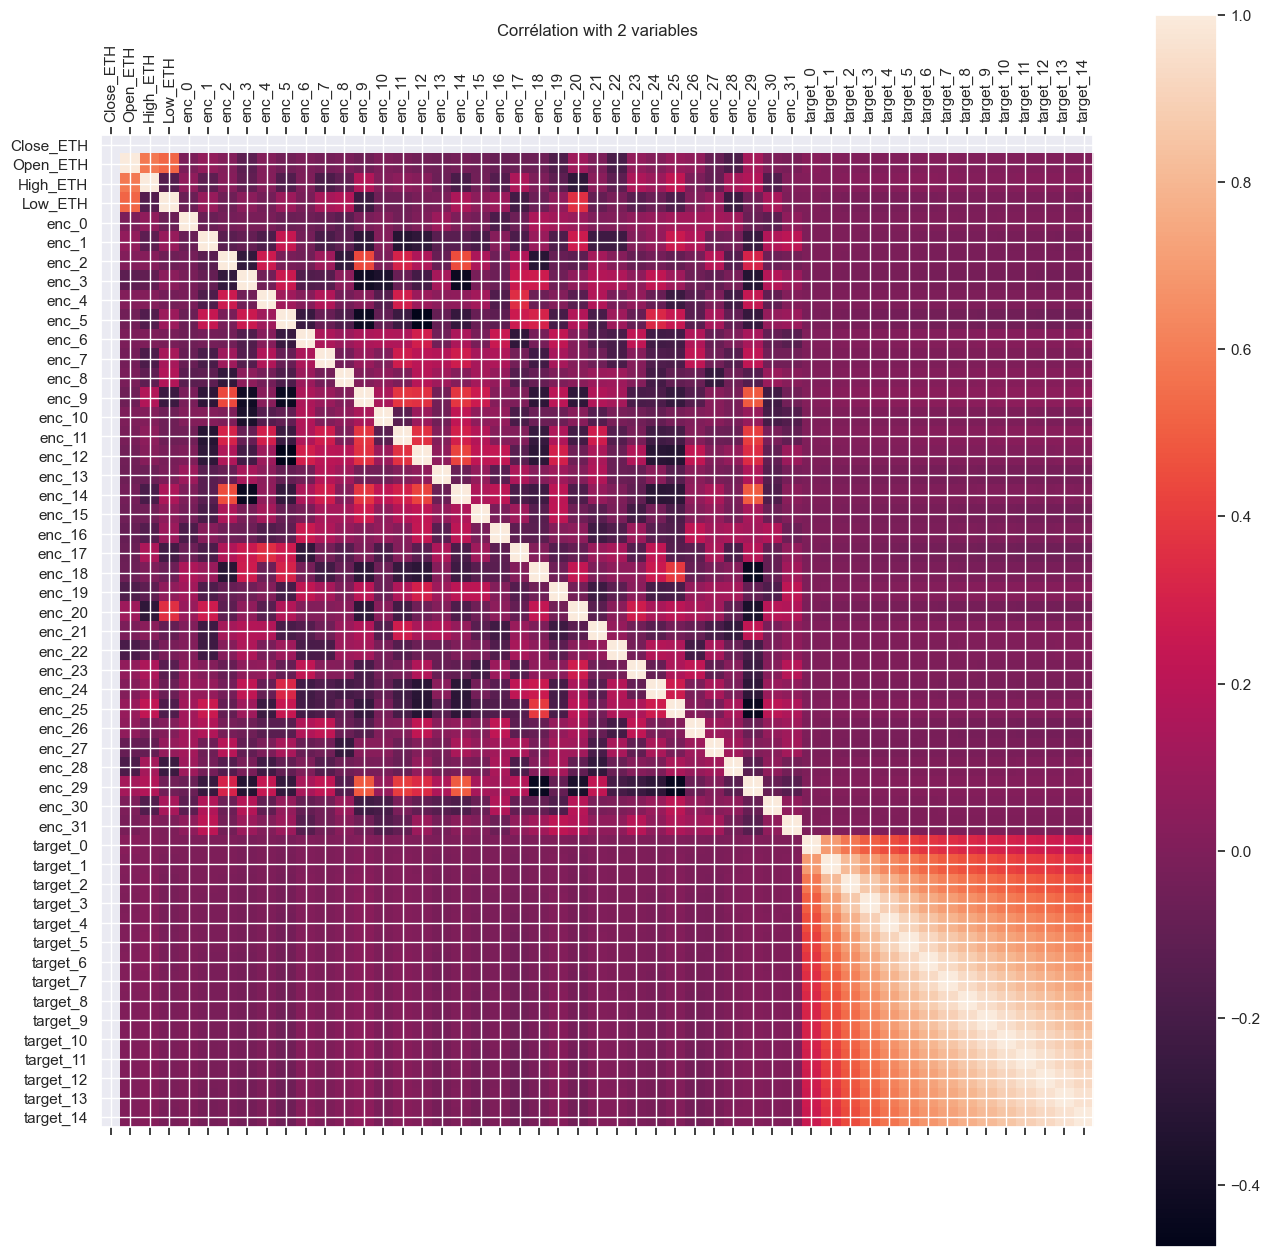

In [114]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)

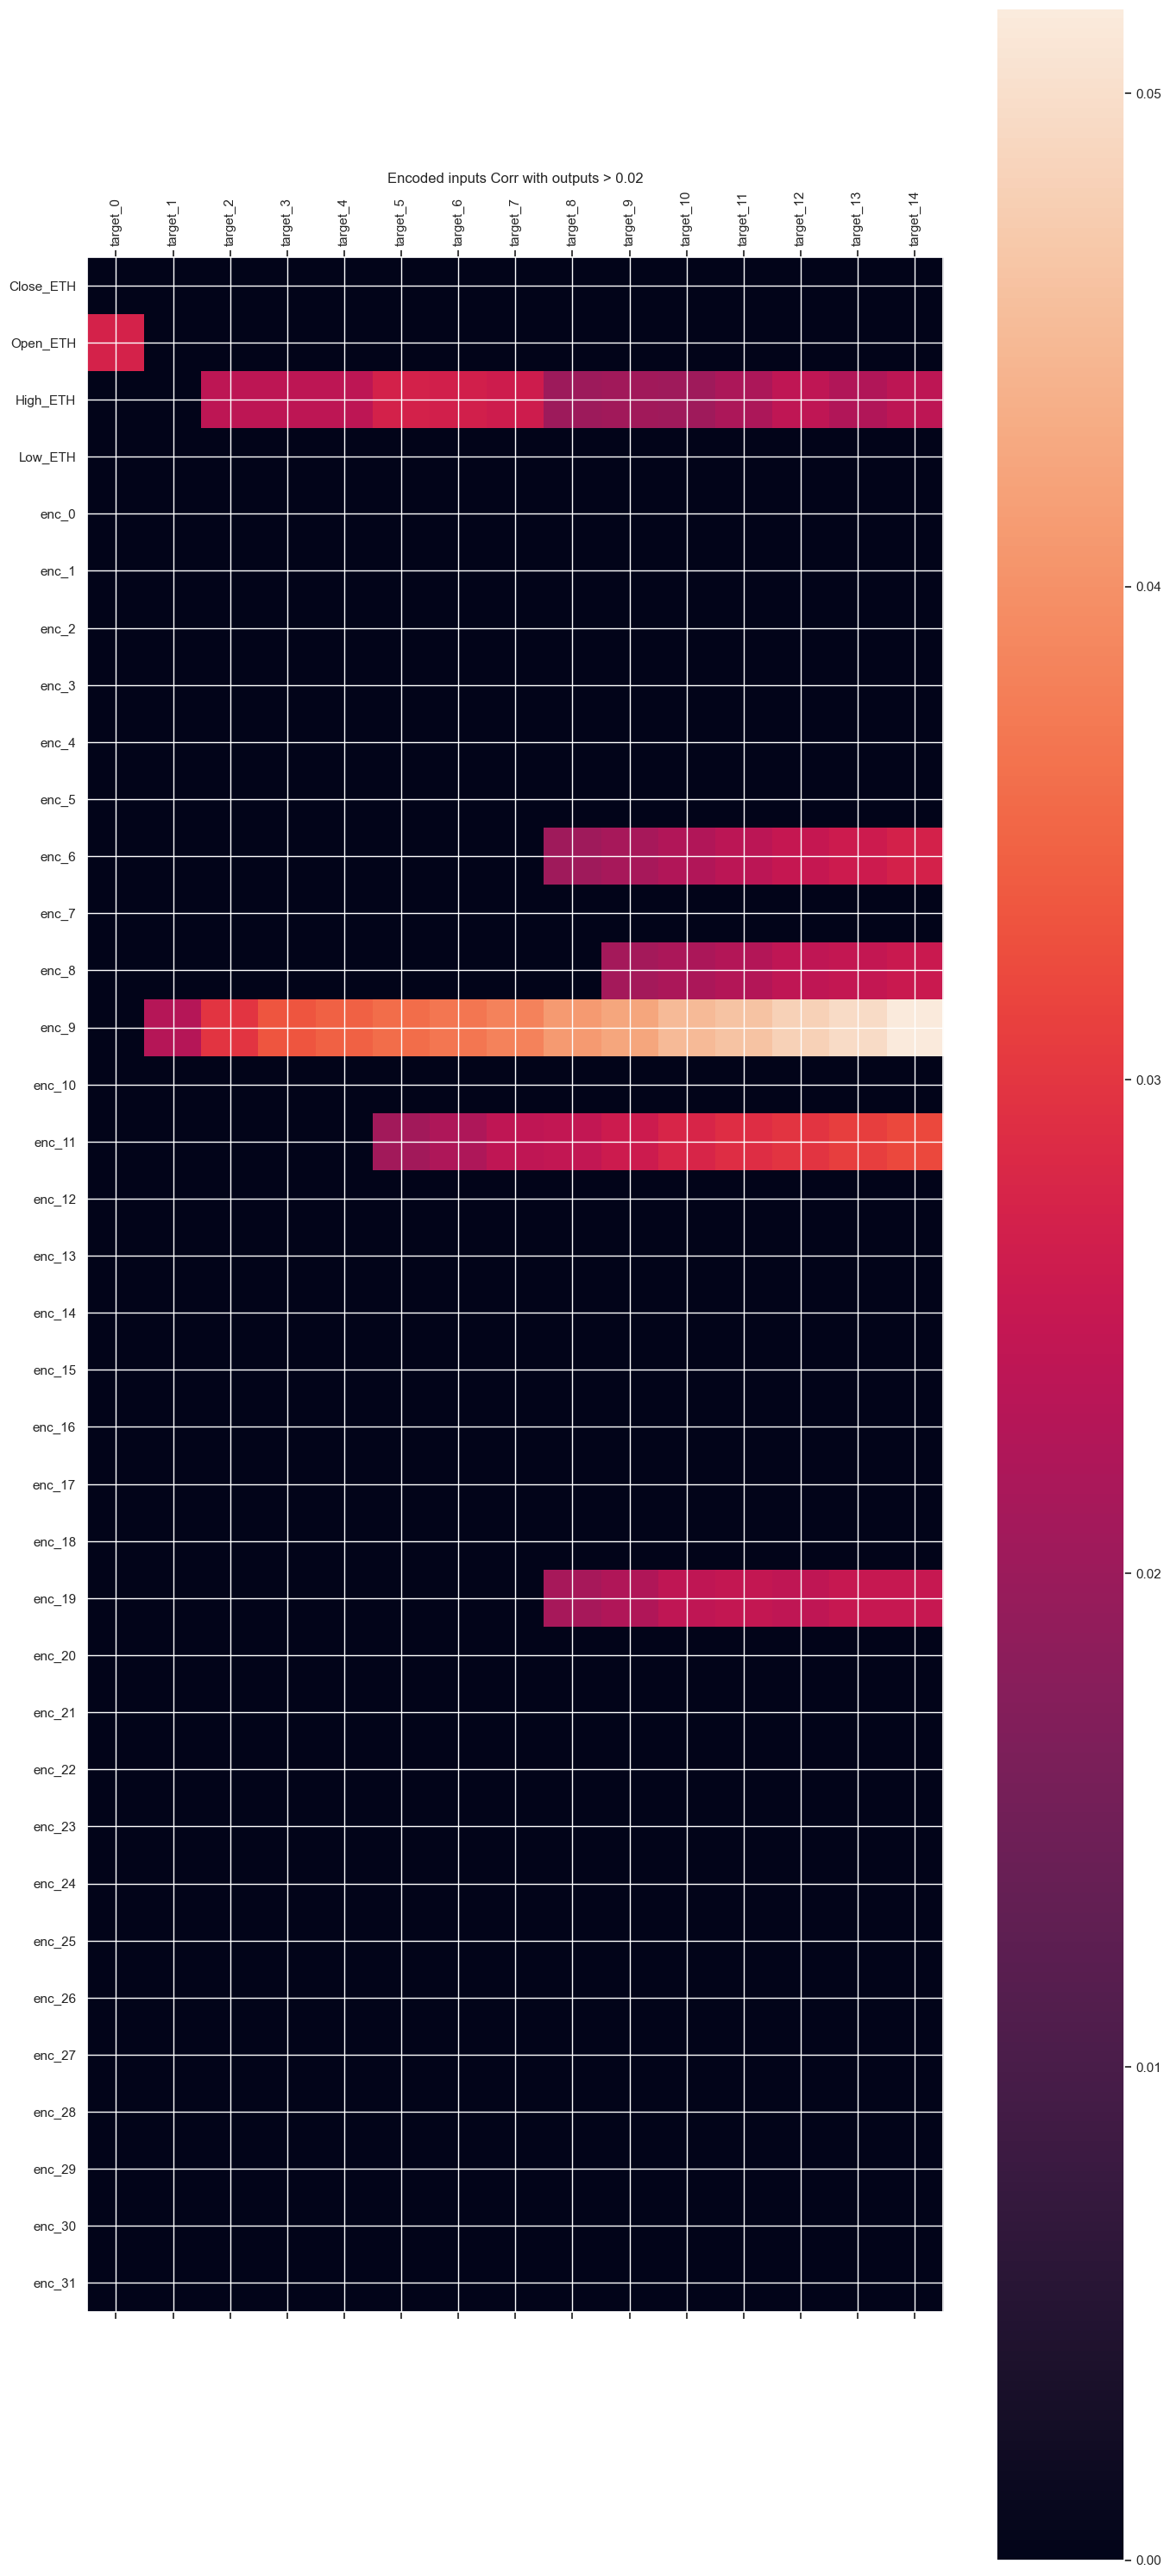

In [117]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")


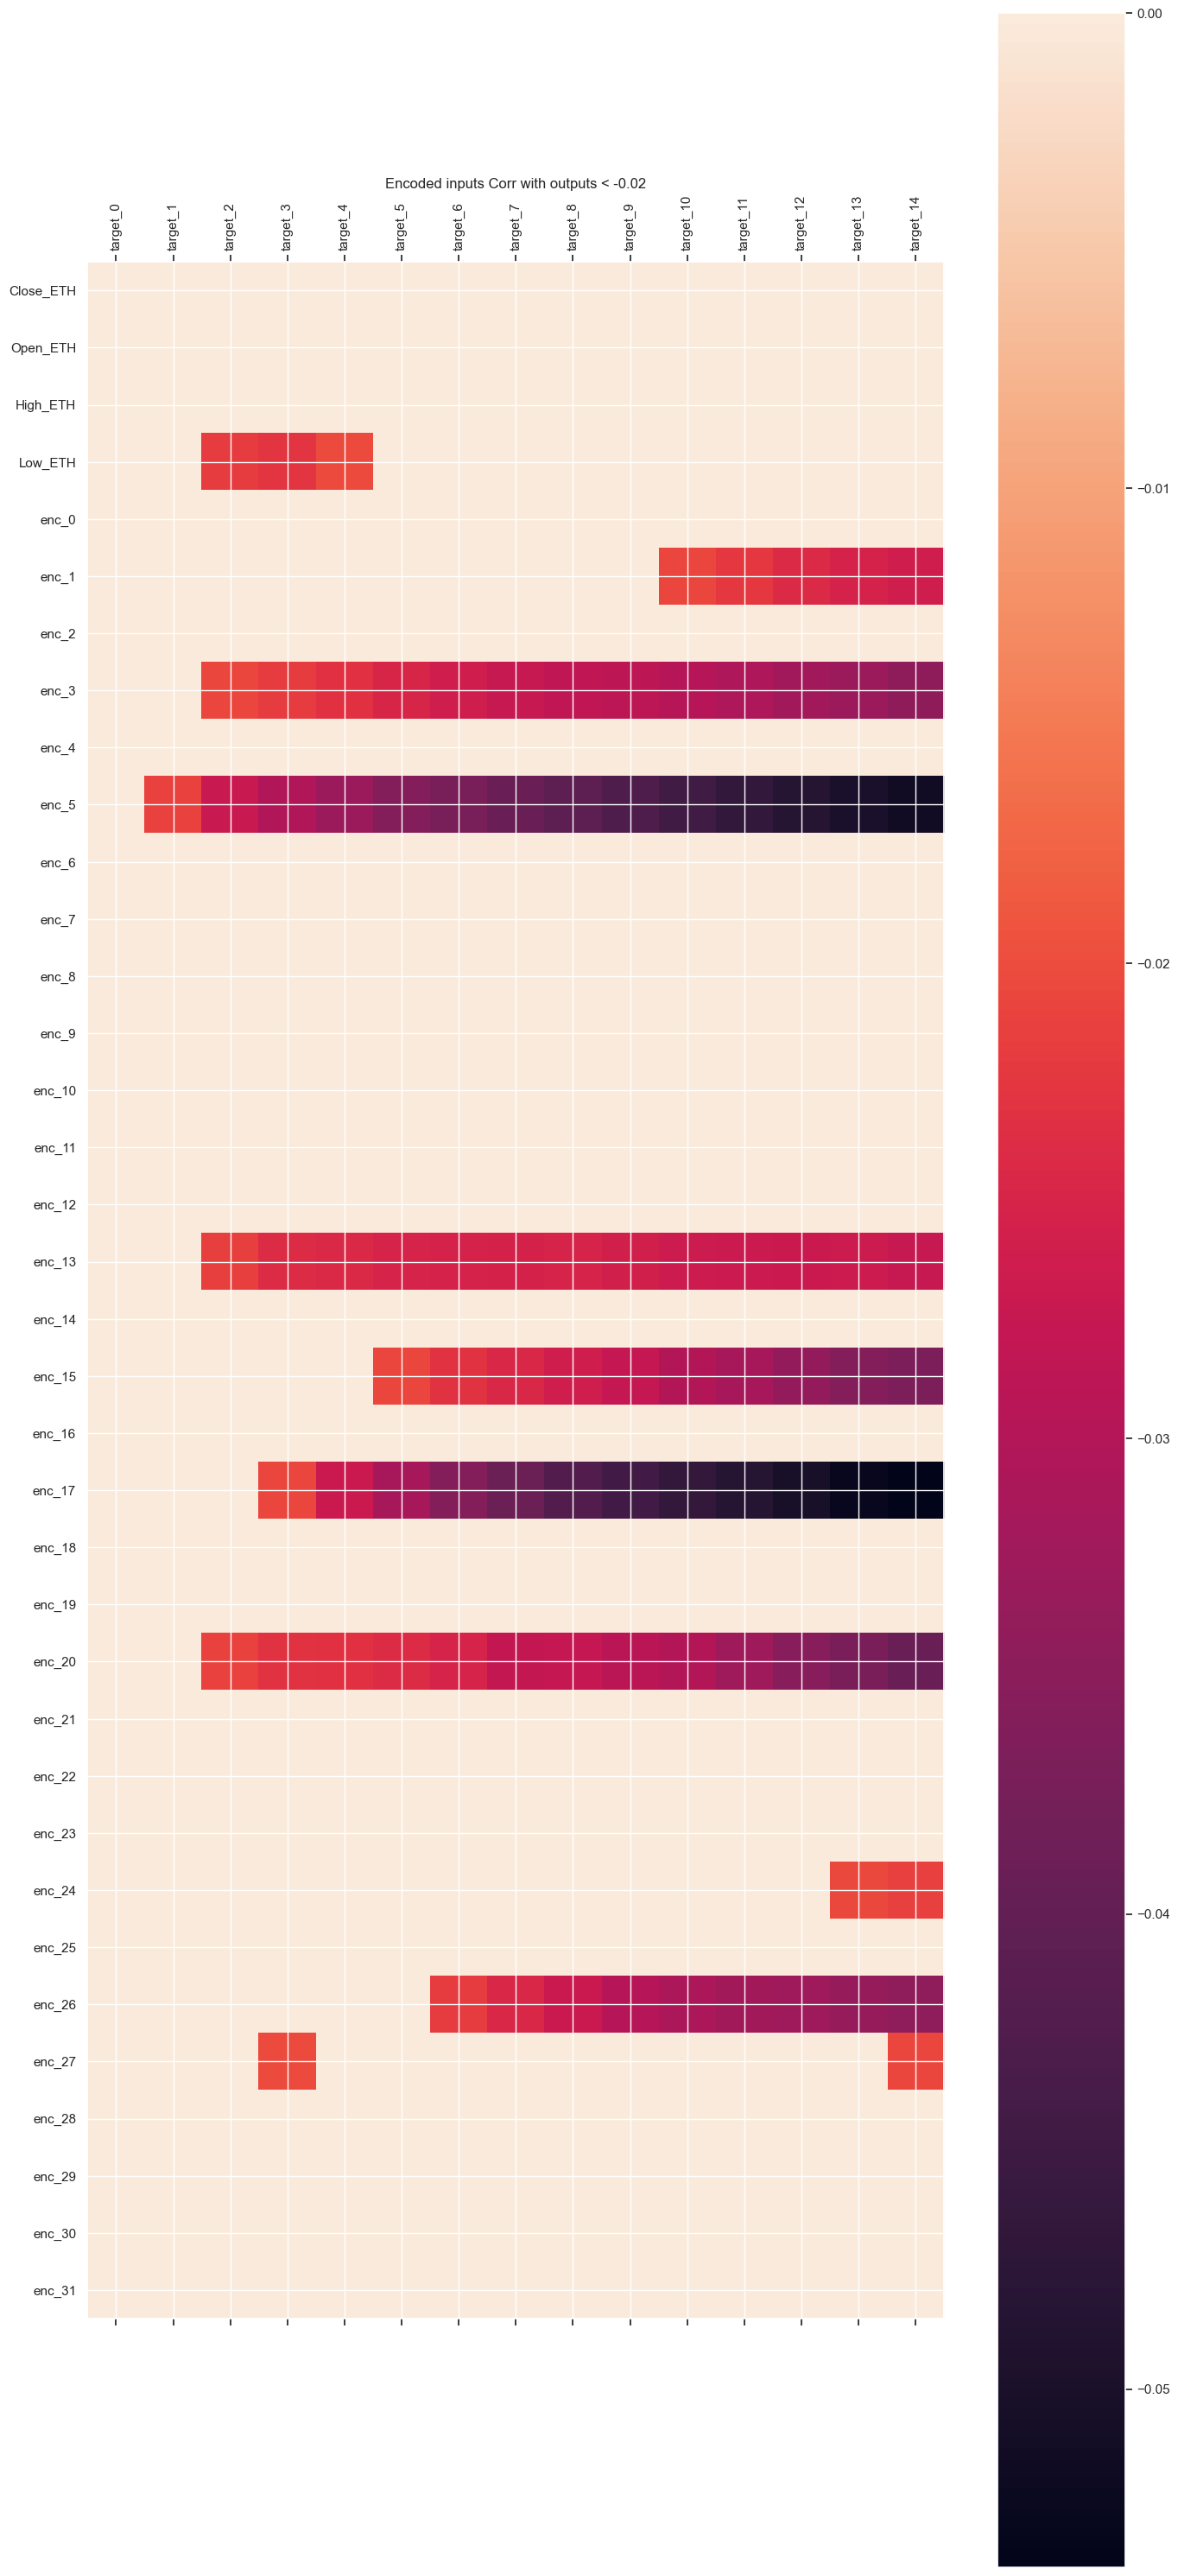

In [118]:
fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)

#### Auto select features 

In [119]:
MODE_AUTO_SELECT

1

In [120]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[1, 3, 5, 6, 8, 9, 11, 13, 15, 17, 19, 20, 24, 26, 27]
nb encoded features:  15


In [121]:
X_train_.shape

(52614, 48, 36)

In [122]:
np.array(list(range(4)) + list_i_enc_select)

array([ 0,  1,  2,  3,  1,  3,  5,  6,  8,  9, 11, 13, 15, 17, 19, 20, 24,
       26, 27])

In [124]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  5,  7,  9, 10, 12, 13, 15, 17, 19, 21, 23, 24, 28,
       30, 31])

In [125]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [126]:
X_train_.shape

(52614, 48, 19)

#### Train

Epoch 1/30
1645/1645 [==============================] - 43s 25ms/step - loss: 1.0467 - val_loss: 0.2733
Epoch 2/30
1645/1645 [==============================] - 41s 25ms/step - loss: 0.9421 - val_loss: 0.2748
Epoch 3/30
1645/1645 [==============================] - 40s 25ms/step - loss: 0.8733 - val_loss: 0.2798
Epoch 4/30
1645/1645 [==============================] - 40s 25ms/step - loss: 0.8093 - val_loss: 0.2704
Epoch 5/30
1645/1645 [==============================] - 41s 25ms/step - loss: 0.7546 - val_loss: 0.3034
Epoch 6/30
1645/1645 [==============================] - 42s 25ms/step - loss: 0.7134 - val_loss: 0.2842
Epoch 7/30
1645/1645 [==============================] - 41s 25ms/step - loss: 0.6908 - val_loss: 0.3021
Epoch 8/30
1645/1645 [==============================] - 42s 25ms/step - loss: 0.6537 - val_loss: 0.2912
Epoch 9/30
1645/1645 [==============================] - 41s 25ms/step - loss: 0.6256 - val_loss: 0.3226
Epoch 10/30
1645/1645 [==============================] - 40s 25m

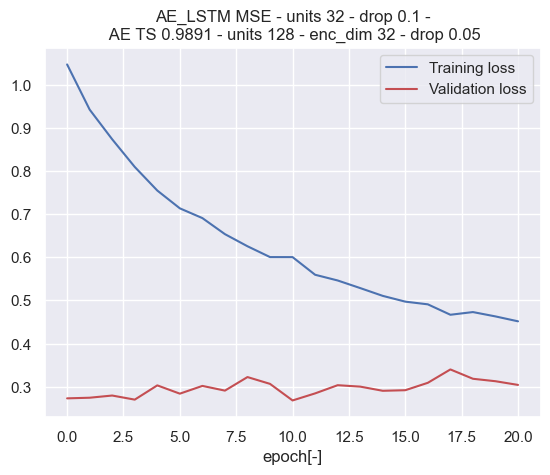

Save model:  data/mdl_predict_autoenc_lstm


INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


In [127]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 30
patience = 10
dropout_rate = 0.1
n_units = 32
seed = 0

if MODE_TRAIN_PREDICTOR:

    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    #optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
    #                      nesterov=nesterov)
    optim = tf.optimizers.Adam()
    if patience is not None:
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                        verbose=1, patience=patience,
                                        restore_best_weights=True)
    # create model
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(
        n_units,
        return_sequences=False,
        input_shape=X_train_.shape[-2:],
        )
    )
    multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
    #multi_step_model.add(tf.keras.layers.BatchNormalization())
    multi_step_model.add(tf.keras.layers.LayerNormalization())
    multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history = multi_step_model.fit(
            X_train_, y_train_sca, epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_, y_test_sca), 
            verbose=1,
        )
    else:
        multi_step_history = multi_step_model.fit(
            X_train_, y_train_sca, epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_, y_test_sca), 
            verbose=1, 
            callbacks=[es],
        )
    # eval
    mse_curr = np.min(multi_step_history.history['val_loss'])
    print("MSE TEST : ", mse_curr)

    # plot MSE
    name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
    plot_train_history(
        multi_step_history,
        f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt}",
        saveFolder="data",
    )


if MODE_TRAIN_PREDICTOR:
    print("Save model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model.save(path_mdl_predict_autoenc_lstm)
else:
    print("Load model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
    print(multi_step_model.summary())

#### Results

Save mdl

In [128]:
X_train_.shape

(52614, 48, 19)

Predict

In [130]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

17/17 [==============================] - 0s 9ms/step


Plots

In [131]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(52620,)
(52620,)


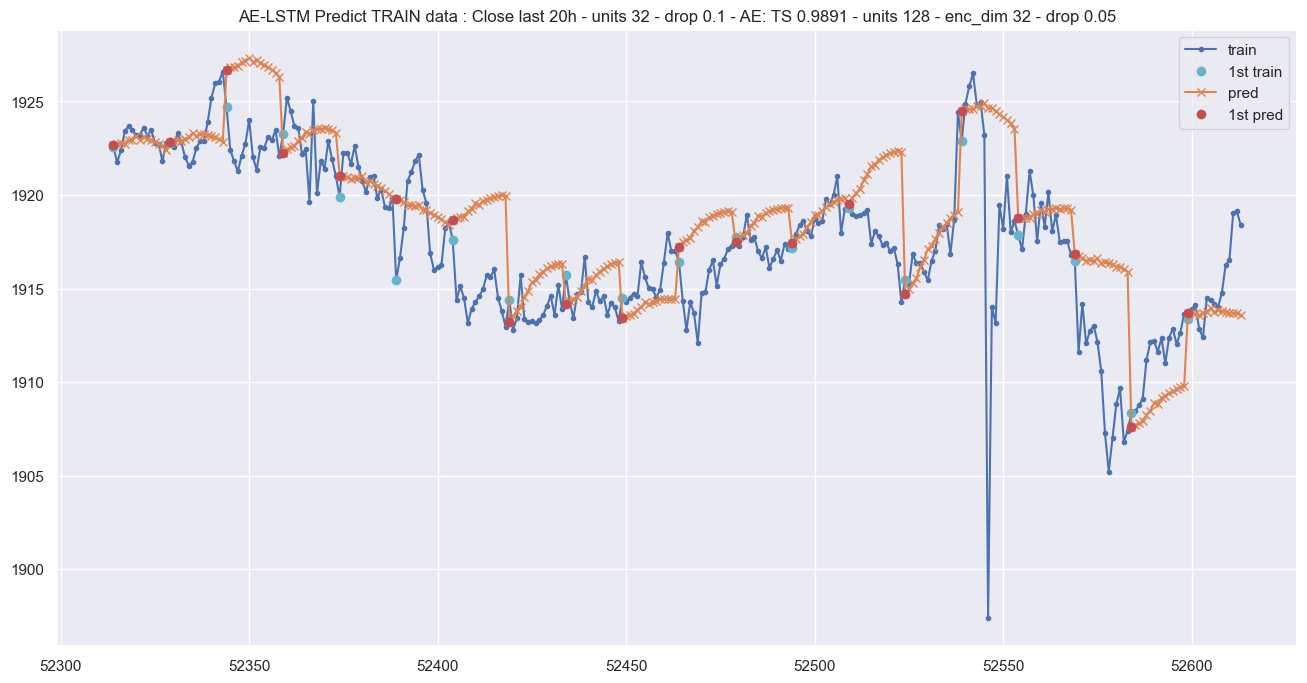

In [132]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

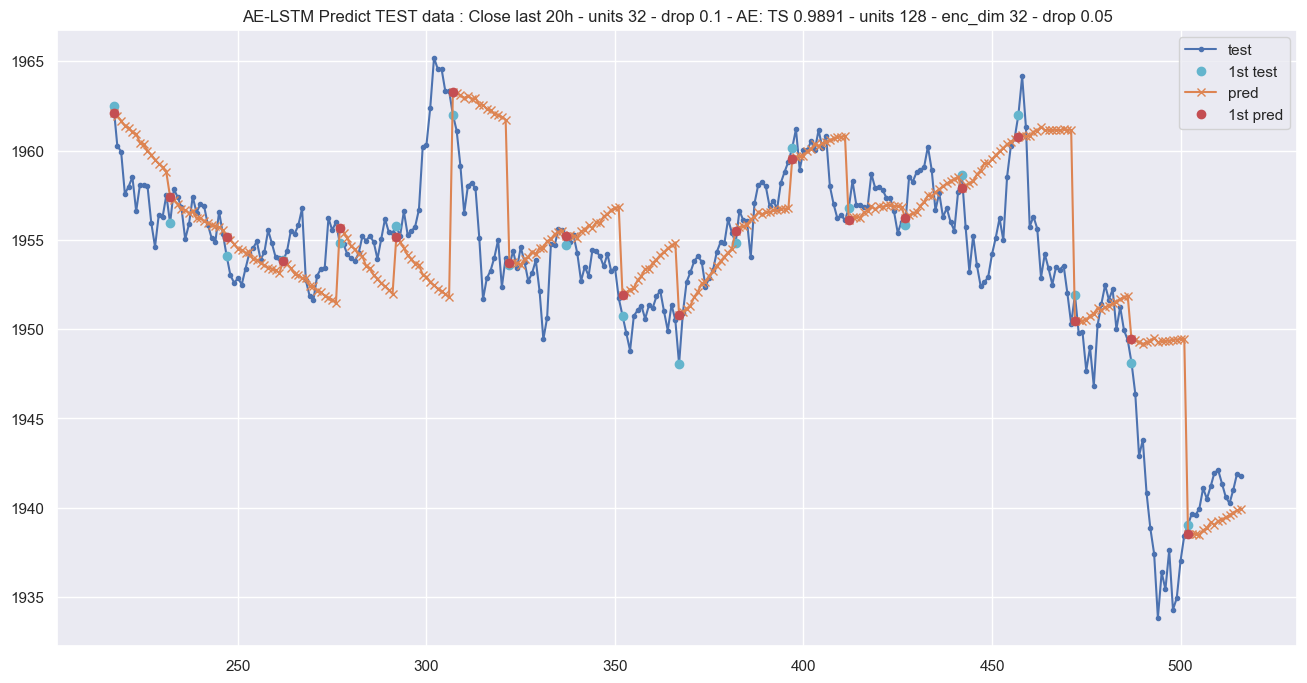

In [133]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

In [140]:
y_test_raw.shape

(515, 15)

In [141]:
y_test_pred_raw.shape

(515, 15)

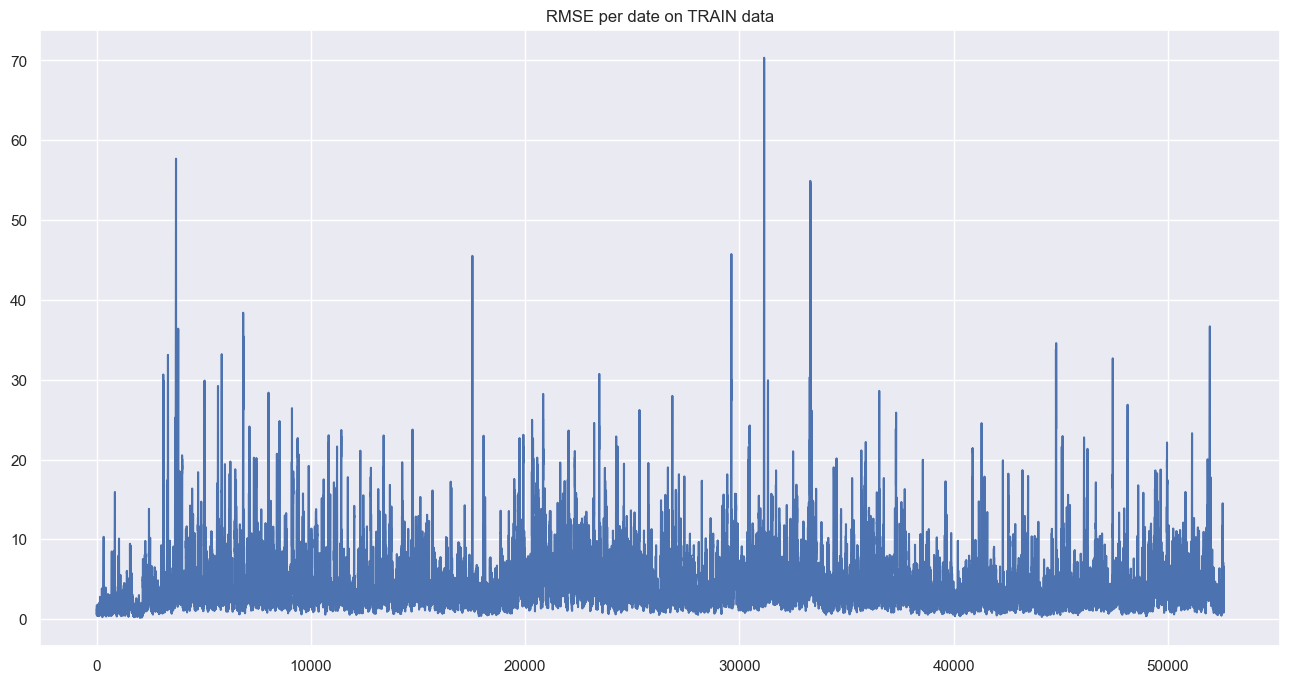

In [137]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

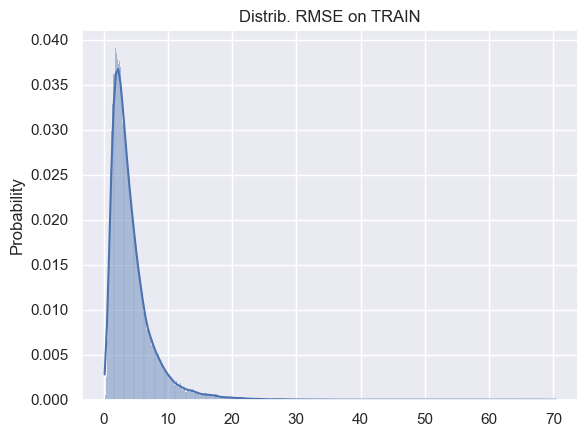

In [135]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 4.34')

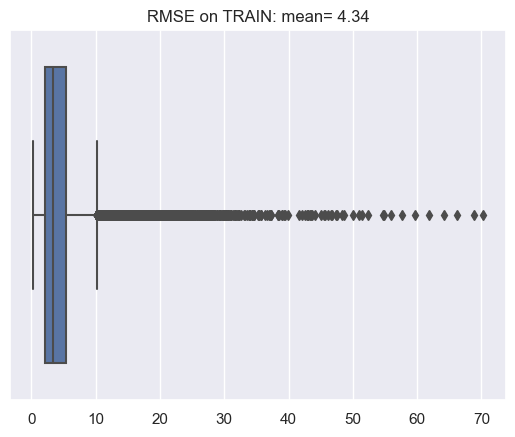

In [138]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

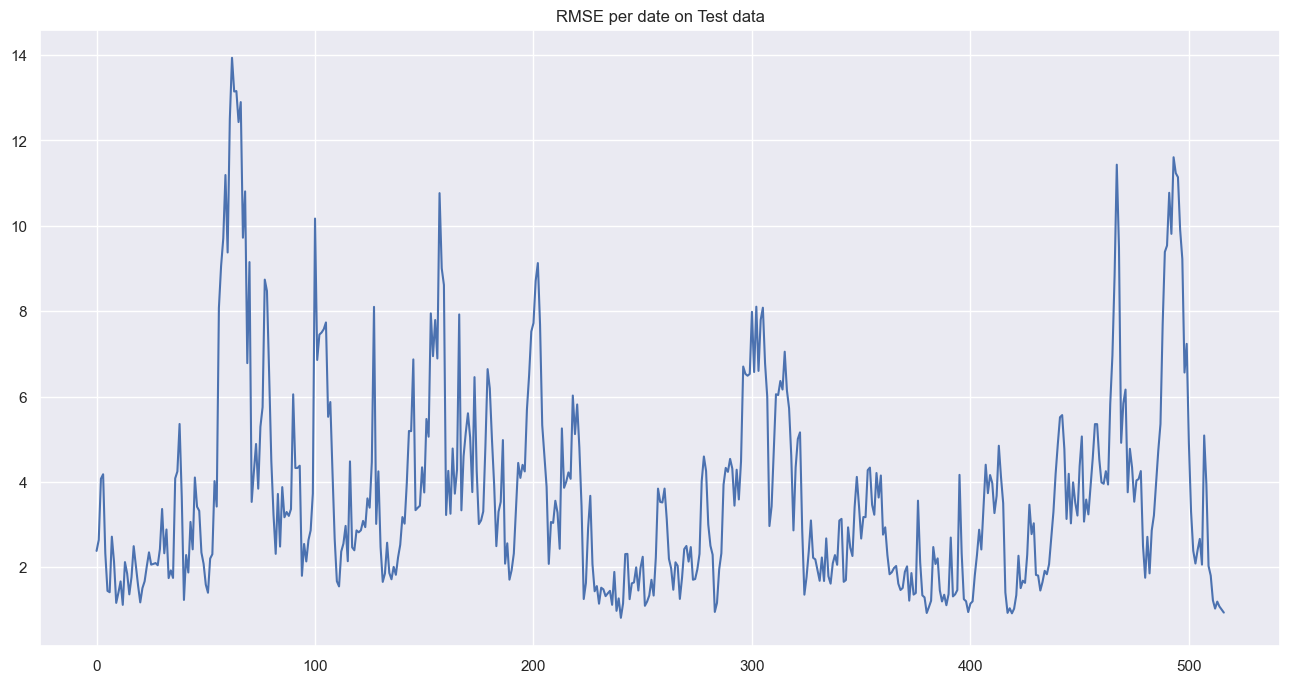

In [139]:
arr_mse = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="mse")

<AxesSubplot: ylabel='Probability'>

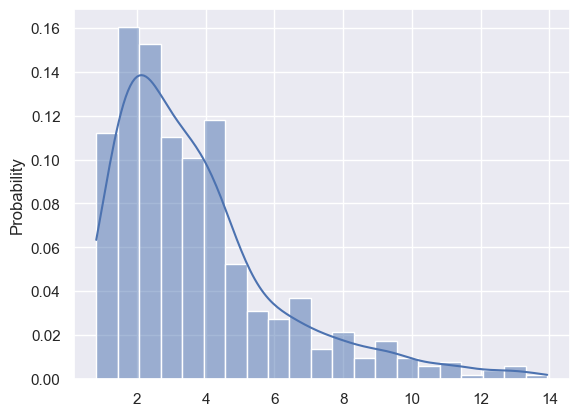

In [140]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)

Text(0.5, 1.0, 'RMSE on TEST: mean= 3.74')

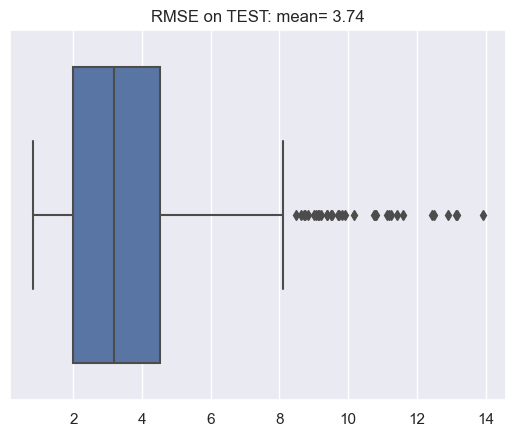

In [141]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [142]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1941.09 1940.49 1941.19 1941.96 1942.1  1941.34 1940.6  1940.24 1941.
 1941.91 1941.79 1941.06 1939.02 1940.49 1941.49]
[1940.06424247 1940.11488842 1940.12552639 1940.13292671 1940.3900879
 1940.54110072 1940.84890786 1940.72472121 1940.91435446 1941.00454588
 1941.14584578 1941.24690642 1941.38751254 1941.50568643 1941.5921777 ]


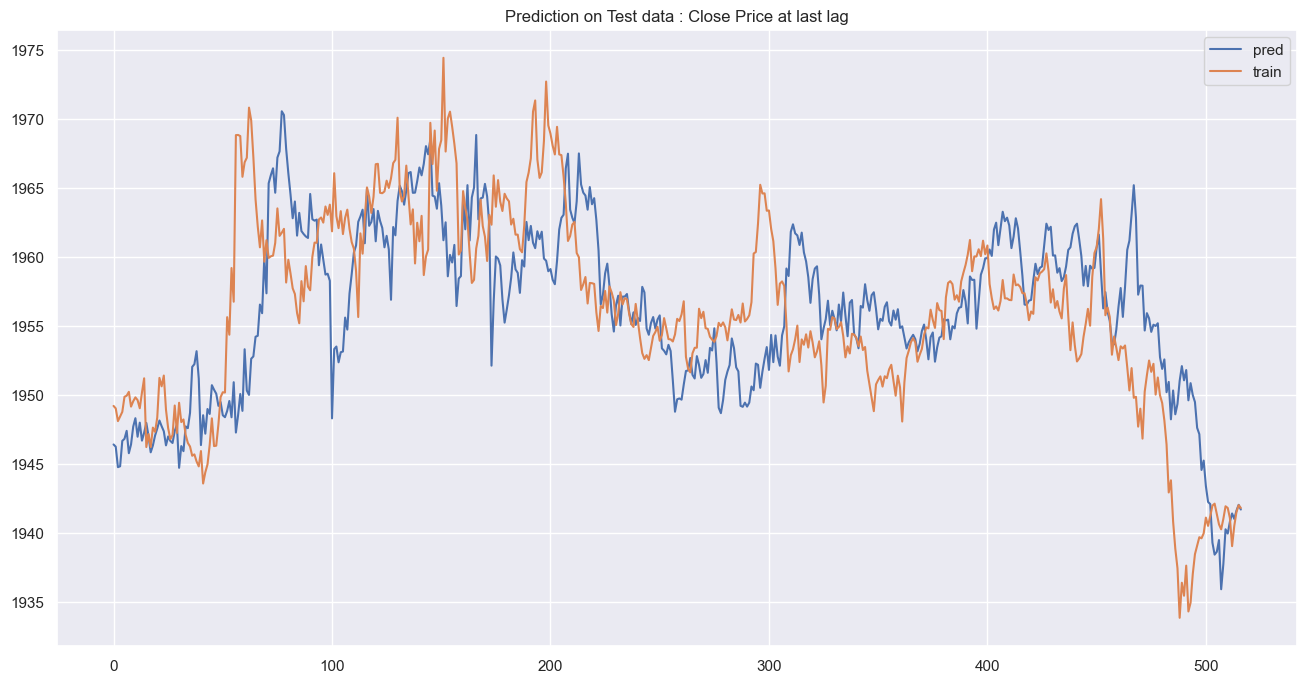

In [143]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

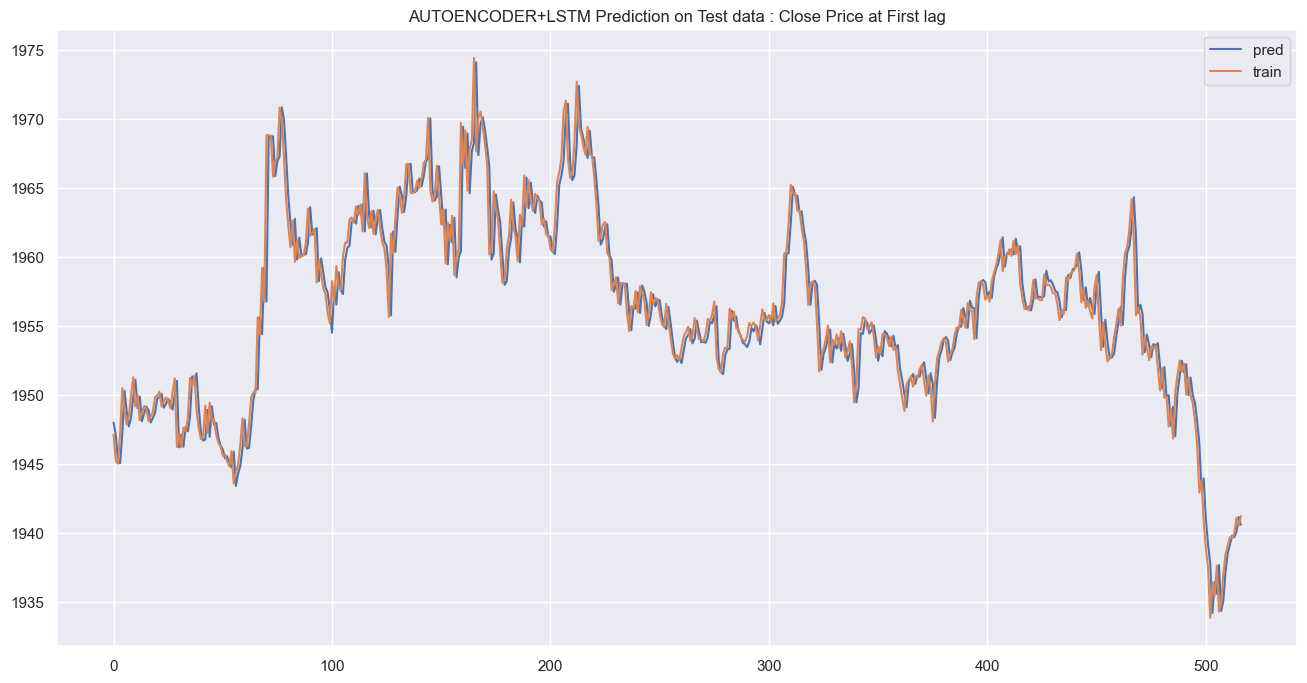

In [144]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

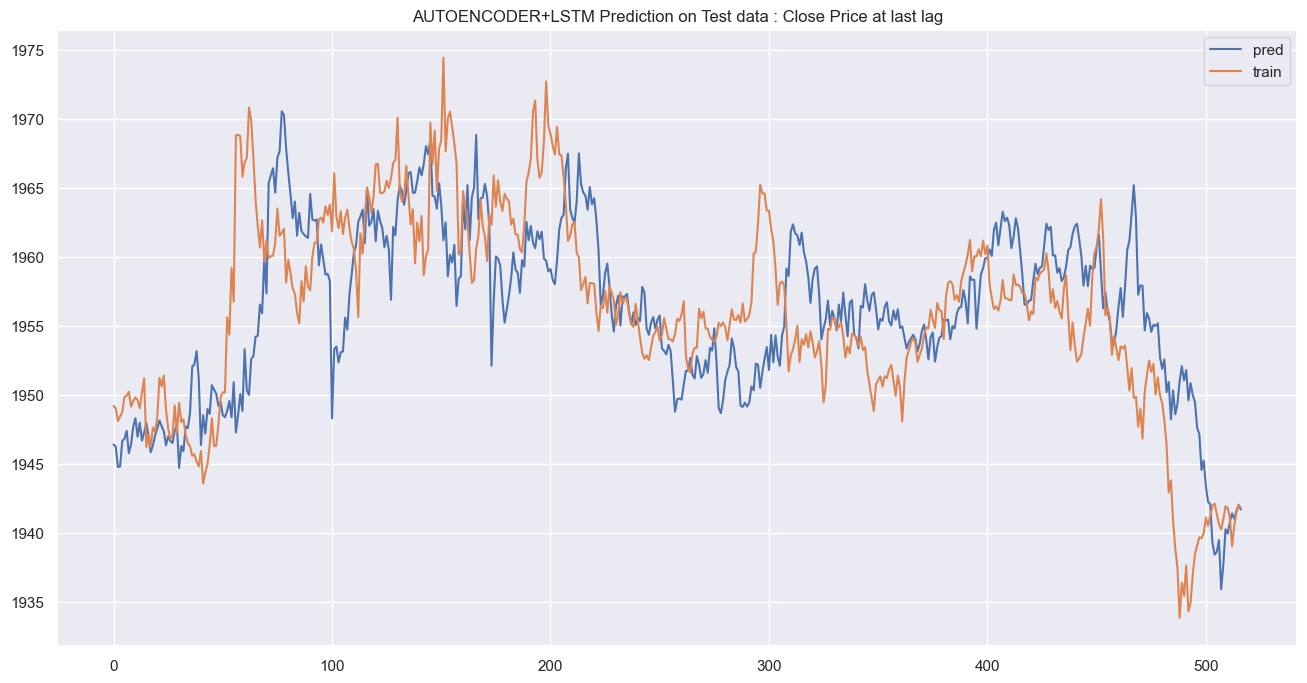

In [145]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [146]:
X_test_sca.shape

(517, 48, 104)

In [147]:
df_feat["Close_ETH"].iloc[-1]

1941.0

In [148]:
df_feat["Close_ETH"].iloc[-1]

1941.0

In [149]:
len(list_i_enc_select)

15

In [150]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1948.98 1946.81 1950.21 1951.4  1952.47 1951.65 1952.23 1950.   1951.24
 1949.95 1949.39 1948.13 1946.39 1942.91 1943.79 1940.81 1938.84 1937.42
 1933.83 1936.37 1935.43 1937.61 1934.29 1934.93 1937.   1938.44 1939.04
 1939.67 1939.59 1939.95 1941.09 1940.49 1941.19 1941.96 1942.1  1941.34
 1940.6  1940.24 1941.   1941.91 1941.79 1941.06 1939.02 1940.49 1941.49
 1941.99 1941.79 1941.  ]
X_last[0,:,0] after divide by price:
[1.00411128 1.0029933  1.00474498 1.00535806 1.00590933 1.00548686
 1.00578568 1.00463679 1.00527563 1.00461103 1.00432251 1.00367336
 1.00277692 1.00098403 1.0014374  0.99990211 0.99888717 0.99815559
 0.99630603 0.99761463 0.99713035 0.99825348 0.99654302 0.99687275
 0.99793921 0.99868109 0.99899021 0.99931479 0.99927357 0.99945904
 1.00004637 0.99973725 1.00009789 1.00049459 1.00056672 1.00017517
 0.99979392 0.99960845 1.         1.00046883 1.00040701 1.00003091
 0.99897991 0.99973725 1.00025245 1.00051005 1.00040701 1.      

In [151]:
X_last_encoded_sca.shape

(1, 48, 32)

In [152]:
list_i_enc_select

[1, 3, 5, 6, 8, 9, 11, 13, 15, 17, 19, 20, 24, 26, 27]

In [153]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 48, 15)

In [154]:
X_last_sca[:,:,0:4].shape

(1, 48, 4)

In [155]:
X_train_.shape

(52614, 48, 19)

In [156]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
53252  1688506800000   1939.01   1940.50  1938.86    1940.49    195.4690   
53253  1688507100000   1940.50   1941.50  1940.49    1941.49    125.0414   
53254  1688507400000   1941.50   1942.00  1941.15    1941.99    159.0702   
53255  1688507700000   1942.00   1942.25  1941.78    1941.79    121.6889   
53256  1688508000000   1941.79   1942.42  1939.34    1941.00   1032.1089   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1726.402881       1725.739815   
1      2023-01-01 00:05:00       1726.402881       1725.739815   
2      2023-01-01 00:10:00       1726.402881       1725.739815   
3      2023-01-01 00:15:00       1726.402881       1725.739815   
4      2023-01-01 00:20:00       1726.402881       1725.739815   
...                    ...               ...               ...   
53252  2023-07-04 21:40:00       1943.560000       1950.035000   
53253  2023-07-04 21:45:00       1942.052500       1948.790000   
53254  2023-07-04 21:50:00       1941.727500       1948.575000   
53255  2023-07-04 21:55:00       1941.095000       1948.575000   
53256  2023-07-04 22:00:00       1940.737500       1948.575000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
53252        1937.125  ...         NaN            NaN           NaN   
53253        1937.125  ...         NaN            NaN           NaN   
53254        1937.395  ...         NaN            NaN           NaN   
53255        1937.395  ...         NaN            NaN           NaN   
53256        1937.395  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53252               NaN         0.0               NaN         0.0      0.0   
53253               NaN         0.0               NaN         0.0      0.0   
53254               NaN         0.0               NaN         0.0      0.0   
53255               NaN         0.0               NaN         0.0      0.0   
53256               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
53252                  NaN  False  
53253                  NaN  False  
53254                  NaN  False  
53255                  NaN  False  
53256                  NaN  False  

[53257 rows x 136 columns]

In [157]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [158]:
y_last_pred_unscaled

array([[1.0000215 , 1.0000175 , 0.9999715 , 0.99993247, 1.0000117 ,
        1.0000197 , 1.0001322 , 1.0000169 , 1.0000647 , 1.00006   ,
        1.0000885 , 1.0000887 , 1.000132  , 1.000148  , 1.0001588 ]],
      dtype=float32)

In [159]:
df_feat["Close_ETH"].iloc[-1]

1941.0

In [160]:
y_last_pred_raw

array([[1941.0416, 1941.034 , 1940.9447, 1940.8689, 1941.0227, 1941.0382,
        1941.2566, 1941.0328, 1941.1256, 1941.1163, 1941.1716, 1941.1721,
        1941.2561, 1941.2874, 1941.3082]], dtype=float32)

In [161]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [162]:
list_pred

[1940.8689,
 1941.0227,
 1941.0382,
 1941.2566,
 1941.0328,
 1941.1256,
 1941.1163,
 1941.1716,
 1941.1721,
 1941.2561,
 1941.2874,
 1941.3082]

In [163]:
save_list(list_pred, path_save_pred_vals)

In [164]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [165]:
list_pred_reload

[1940.8689,
 1941.0227,
 1941.0382,
 1941.2566,
 1941.0328,
 1941.1256,
 1941.1163,
 1941.1716,
 1941.1721,
 1941.2561,
 1941.2874,
 1941.3082]